# Analisi Predittive di Serie Numeriche

Questo notebook si propone come riassunto della nostra esperienza nel tirocinio sulla previsione di serie numeriche temporali.
Il tirocinio è stato diviso in due fasi, ciascuna della quali corrisponde a un dataset differente:

- previsioni su "negozio Albignasego"
- previsioni su "M5 Competition"

Nella prima fase ciascuno di noi ha scelto in totale autonomia che metodo utilizzare per studiare e successivamente prevedere
le serie temporali che ci sono state fornite, mentre la seconda è stata un lavoro di gruppo in cui abbiamo elaborato una soluzione comune per il problema che ci è stato proposto.

## Confronto tra modelli

Nel primo lavoro ci è stato fornito un insieme di dati riguardanti le vendite nel periodo 23/03/2013-29/09/2019 di un negozio di capi di abbigliamento. Abbiamo deciso di concentrarci unicamente sulla serie delle maglie in quanto il comportamento delle serie degli altri capi di abbiagliamento risultava analogo. Abbiamo diviso la serie nei due set di validazione (contenente l'80% delle osservazioni) e uno di validazione (contenente il 20% da confrontare con i risultati delle previsioni) e successivamente ci siamo concentrati sull'applicazione di modelli per le previsioni con lo scopo di trovare quelli che fornissero i risultati migliori.

### Studio della serie

Per lo studio della serie ci siamo serviti di una serie di librerie che potessero fornire una serie di strumenti per estrarre o determinare le sue caratteristiche, oltre alle librerie per la manipolazione dei dati.

In [6]:
import math
import itertools #realizzazione combinazioni per testare tutti i possibili ordini
import numpy as np #strumenti matematici (metriche d'errore etc.)
import pandas as pd #gestione serie temporali/dataframe
import matplotlib.pyplot as plt #stampa dei grafici
import datetime as dt #manipolazione date
from statsmodels.tsa.arima_model import ARIMA #modello ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose #decomposizione serie in componenti
from statsmodels.tsa.stattools import adfuller #metrica Dickey-Fuller per stazionarietà
from statsmodels.tsa.stattools import kpss #metrica kpss per trend stazionarietà
from statsmodels.tsa.stattools import acf, pacf #per la realizzazione dei grafici di autocorrelazione e autorcorrelazione parziale

Per studiare la stagionalità della serie abbiamo utilizzato i grafici di autocorrelazione e autocorrelazione parziale. 
I grafici di autocorrelazione forniscono i valori di autocorrelazione di una serie con i suoi valori spostati di un certo lag, descrivendo quindi la relazione tra i valori della serie in un certo momento siano in relazione con i valori passati. La funzione di autocorrelazione non fa distinzione tra le componenti della serie.
I grafici di autocorrelazione parziale invece trattano la correlazione tra i residui e residui spostati di un certo lag, mettendo in evidenza informazioni nascoste ancora presenti nei residui.

In [19]:
def ac_pac_function(timeseries, pos1=0, pos2=0, lags=40):
    
    """
    Calcola le funzioni di autocorrelazione e autocorrelazione parziale di una serie temporale.
    -----------------
    Parametri:
    -----------------
        timeseries -> la serie temporale resa stazionaria con un metodo qualsiasi (pandas.Series)\n
        lags -> dimensione del grafico (int), default 40\n
    """
    lag_acf = acf(timeseries, nlags=lags, fft=True)
    lag_pacf = pacf(timeseries, nlags=lags, method='ols')
    
    plt.figure(figsize=(40, 20), dpi=80)
    
    #Plot ACF:
    
    plt.subplot(211)     
    plt.plot(lag_acf, color = 'orange')
    
    #Delimito i tre intervalli
    
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.title('Autocorrelation function')
    
    #Plot PACF
    
    plt.subplot(212)
    plt.plot(lag_pacf, color = 'orange')
    
    #Delimito i tre intervalli
    
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [12]:
# Costanti per grandezza testo

SMALL_SIZE = 28 
MEDIUM_SIZE = 30 
BIGGER_SIZE = 32 

# Inizializzazione caratteristiche base dei PLOT

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes 
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title 
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels 
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels 
plt.rc('legend', fontsize=SMALL_SIZE)    # fontsize of the legend
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# COLORI

TSC = 'black'   # training set
VSC = 'black'   # validation set
FC = 'red'      # previsioni
MRC = 'green'   # model results
OLC = 'orange'  # other lines

# STAGIONI

year = 365 # giorni
week = 7
half_year = 183

# STAGIONE 

season = half_year

# caricamento insieme dati e verifica tipo delle colonne (solo per controllo)
# L'insieme di dati contiene la data e il numero di capi di abbigliamento venduti
# in quel giorno (per tipo).
# Faccio in modo che la data sia letta per ottenere una serie temporale

dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./NEGOZIO_ABBIGLIAMENTO/Dati_Albignasego/Whole period.csv', index_col=0, date_parser=dateparse)

# usiamo solo la serie maglie. Il procedimento si può ripetere con ciascun capo...

ts = data['MAGLIE'] 

In [14]:
# Costanti per spezzare la serie temporale sempre nello stesso punto

END_TRAIN = ts.index[int(len(ts) * 0.8)]
START_VALID = ts.index[int(len(ts)*0.8)+1]

# Se si vuole togliere il 29 febbraio 2016 per avere solo anni di 365 giorni. 
"""
ts = ts.drop(labels=[pd.Timestamp('2016-02-29')])
print(ts_totale['2016-02'])
"""

train = ts[pd.date_range(start=ts.index[0], end=ts.index[int(len(ts) * 0.8)], freq='D')]
valid = ts[pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D')]

# Stampa la serie iniziale con suddivisione train e validation (solo per controllo) + rolling mean e std
# Finestra temporale di un anno per calcolare media e std in movimento

rolmean = ts.rolling(window=year).mean()
rolstd = ts.rolling(window=year).std()

# Plot della serie iniziale con rolling mean e rolling std (365 giorni e 182 giorni)

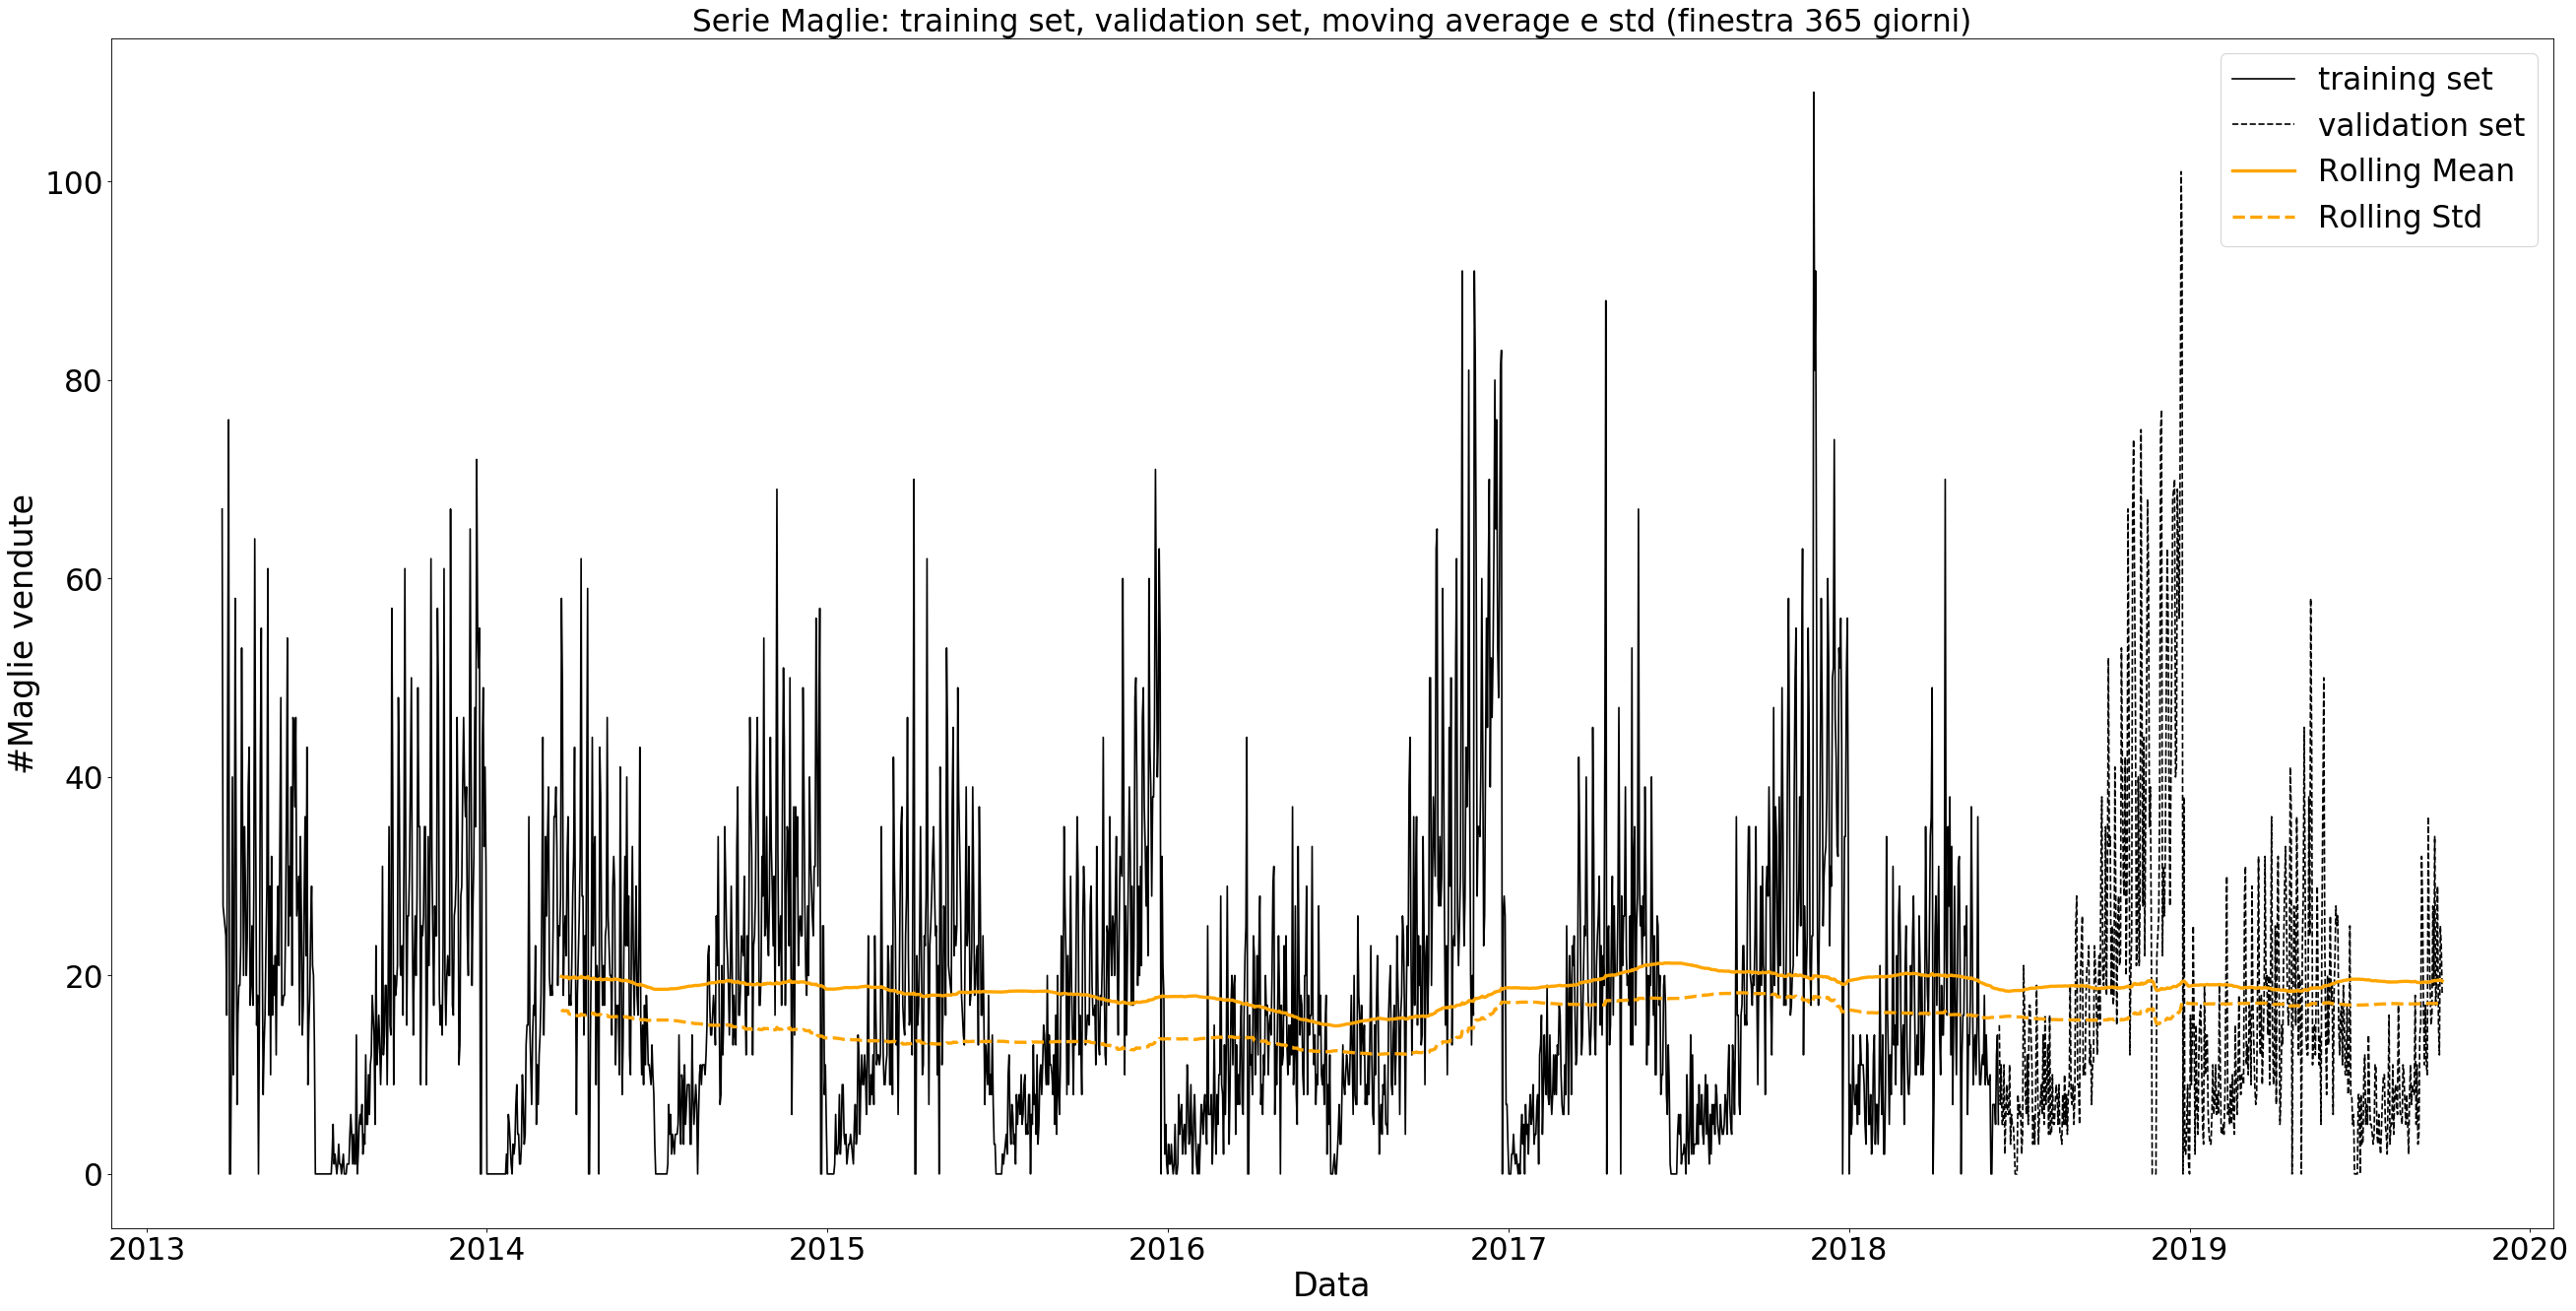

In [14]:
# ANNO

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 365 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

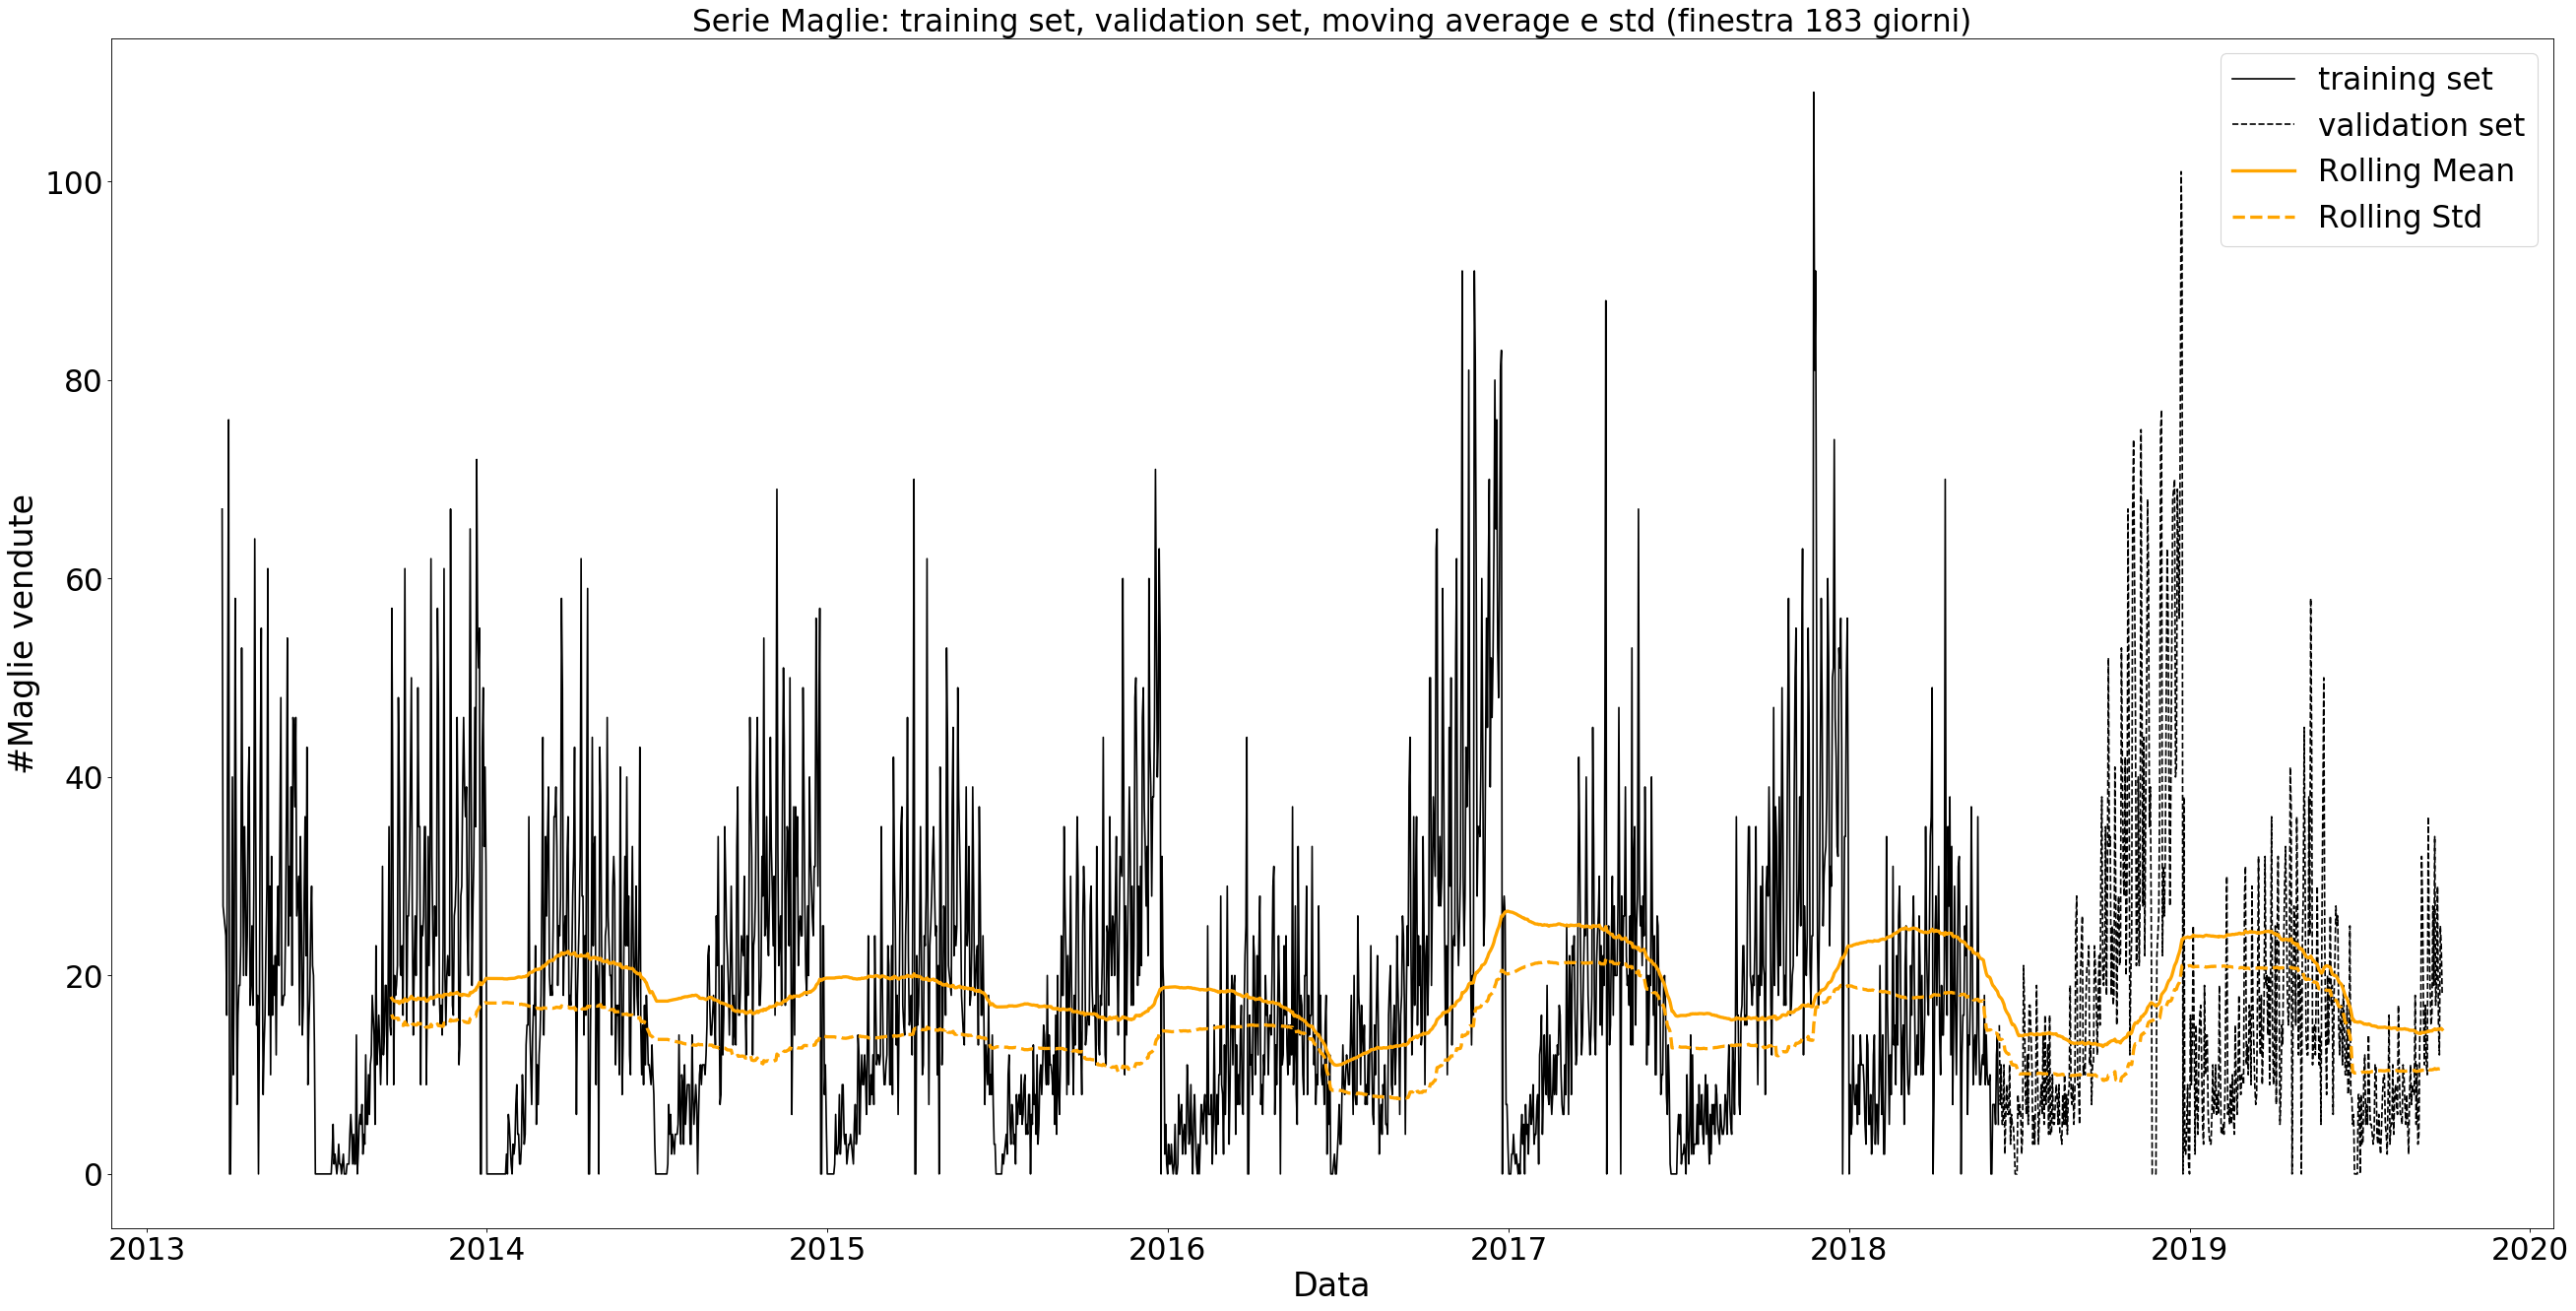

In [16]:
# META' ANNO

rolmean = ts.rolling(window=half_year).mean()
rolstd = ts.rolling(window=half_year).std()

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 183 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

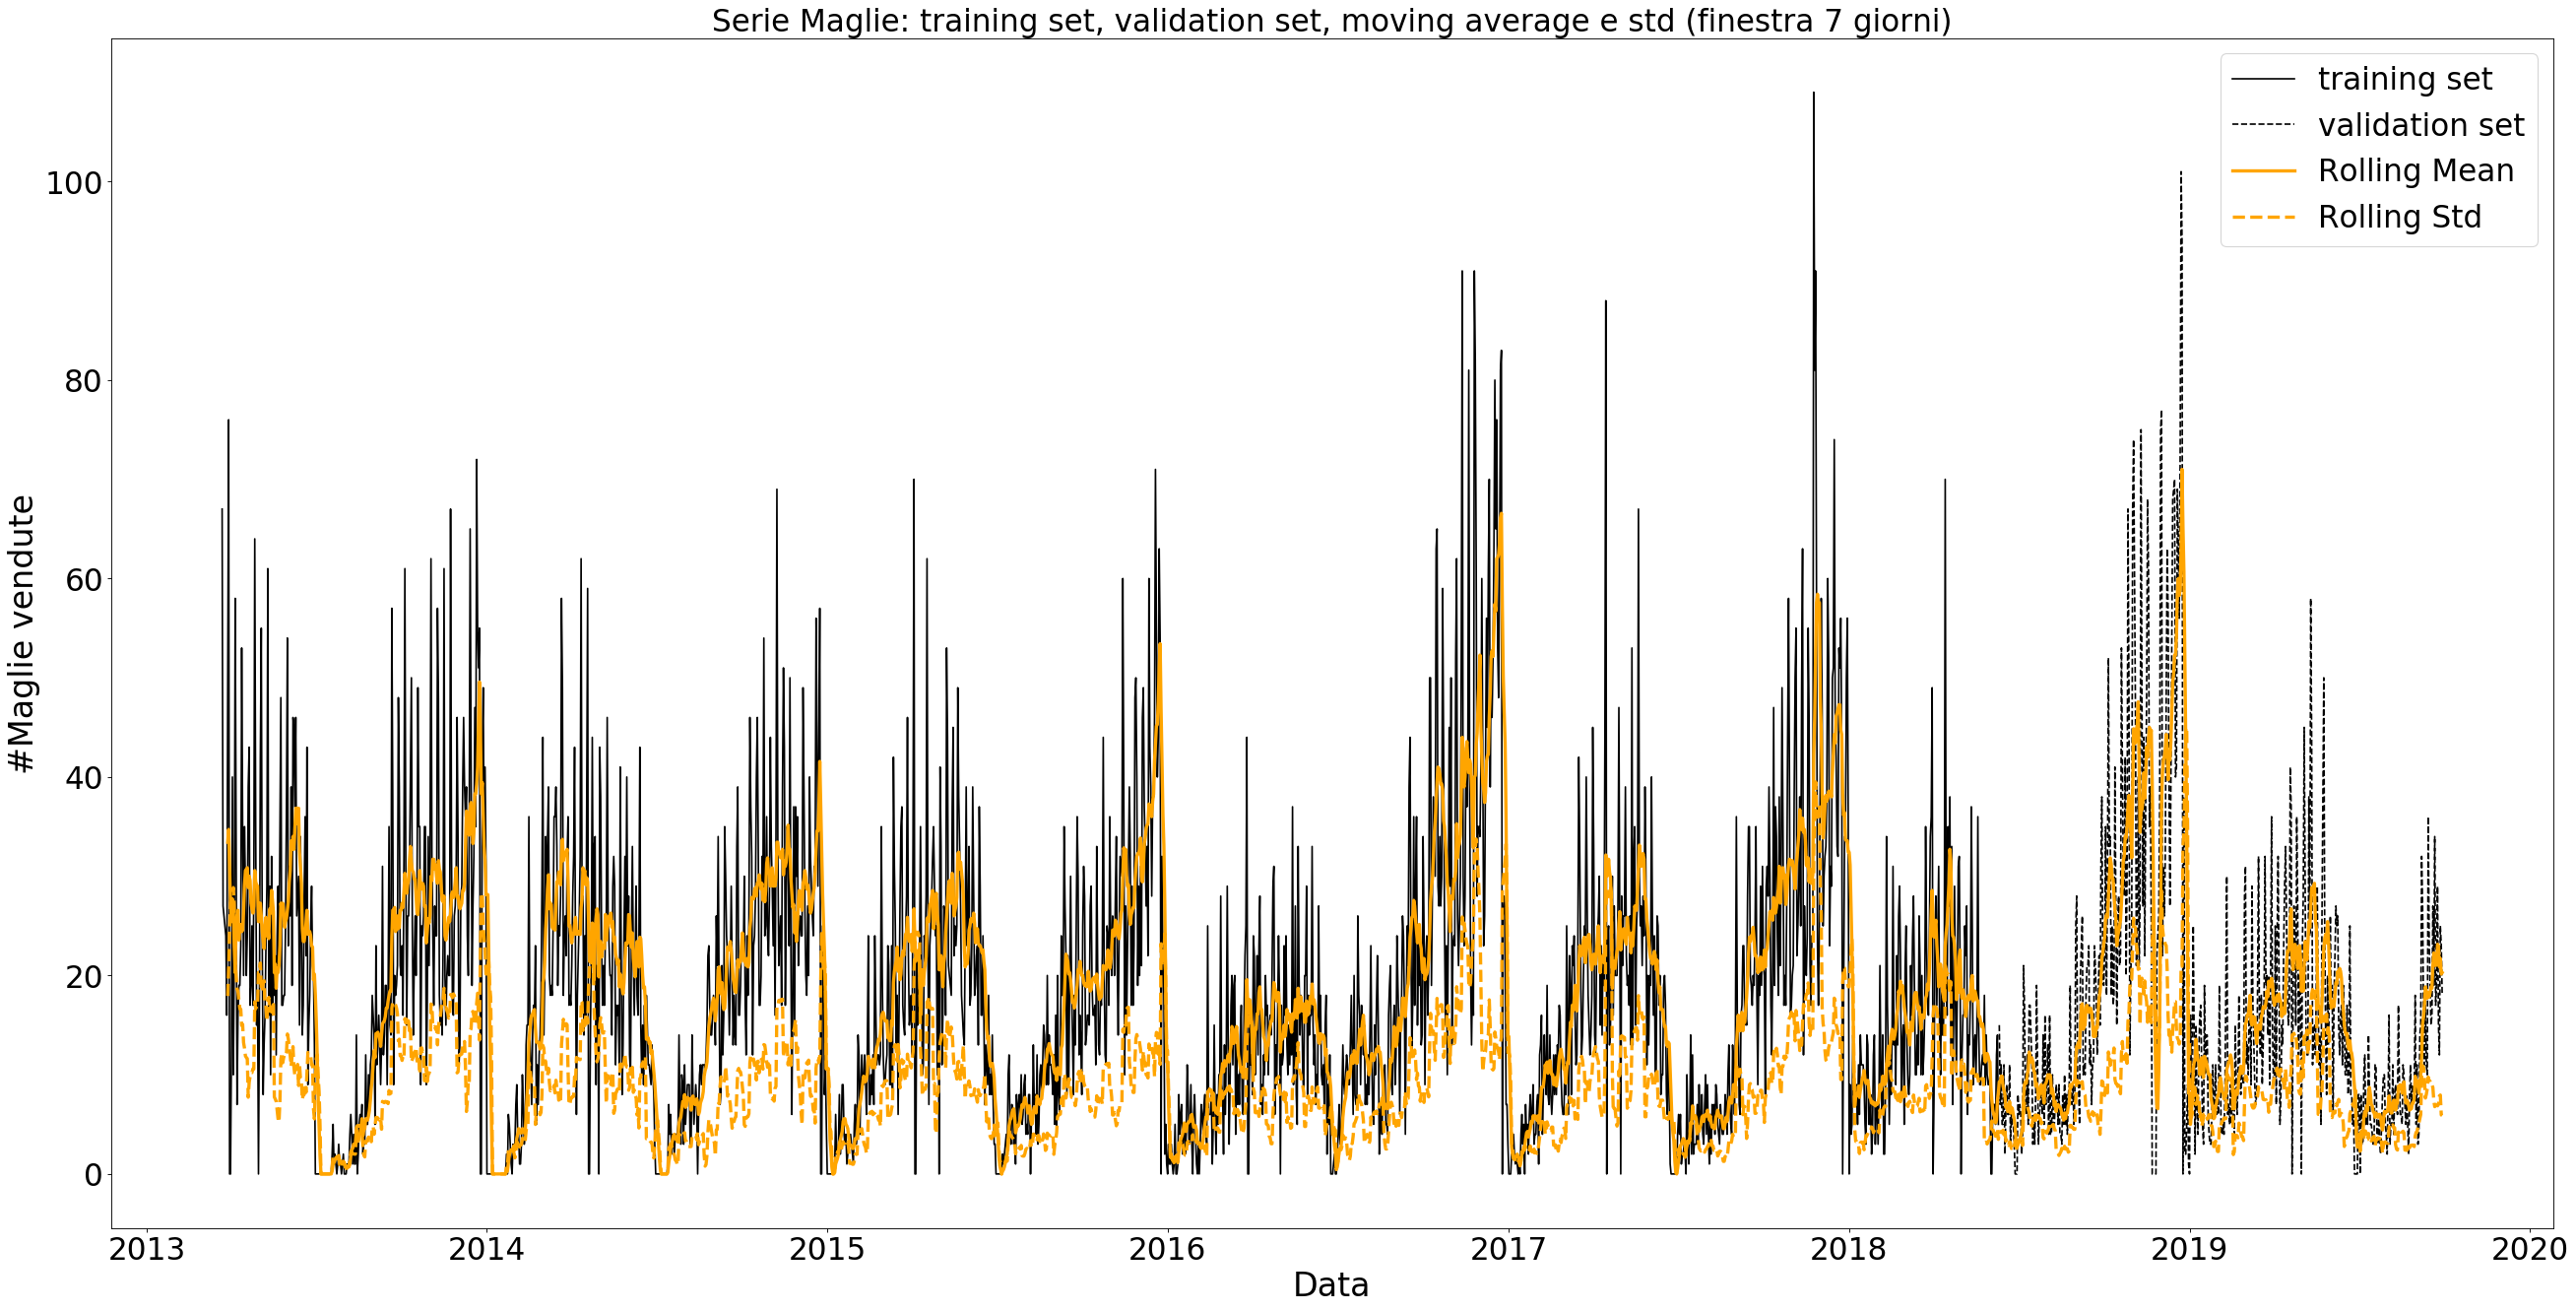

In [17]:
# SETTIMANA

rolmean = ts.rolling(window=week).mean()
rolstd = ts.rolling(window=week).std()

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 7 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

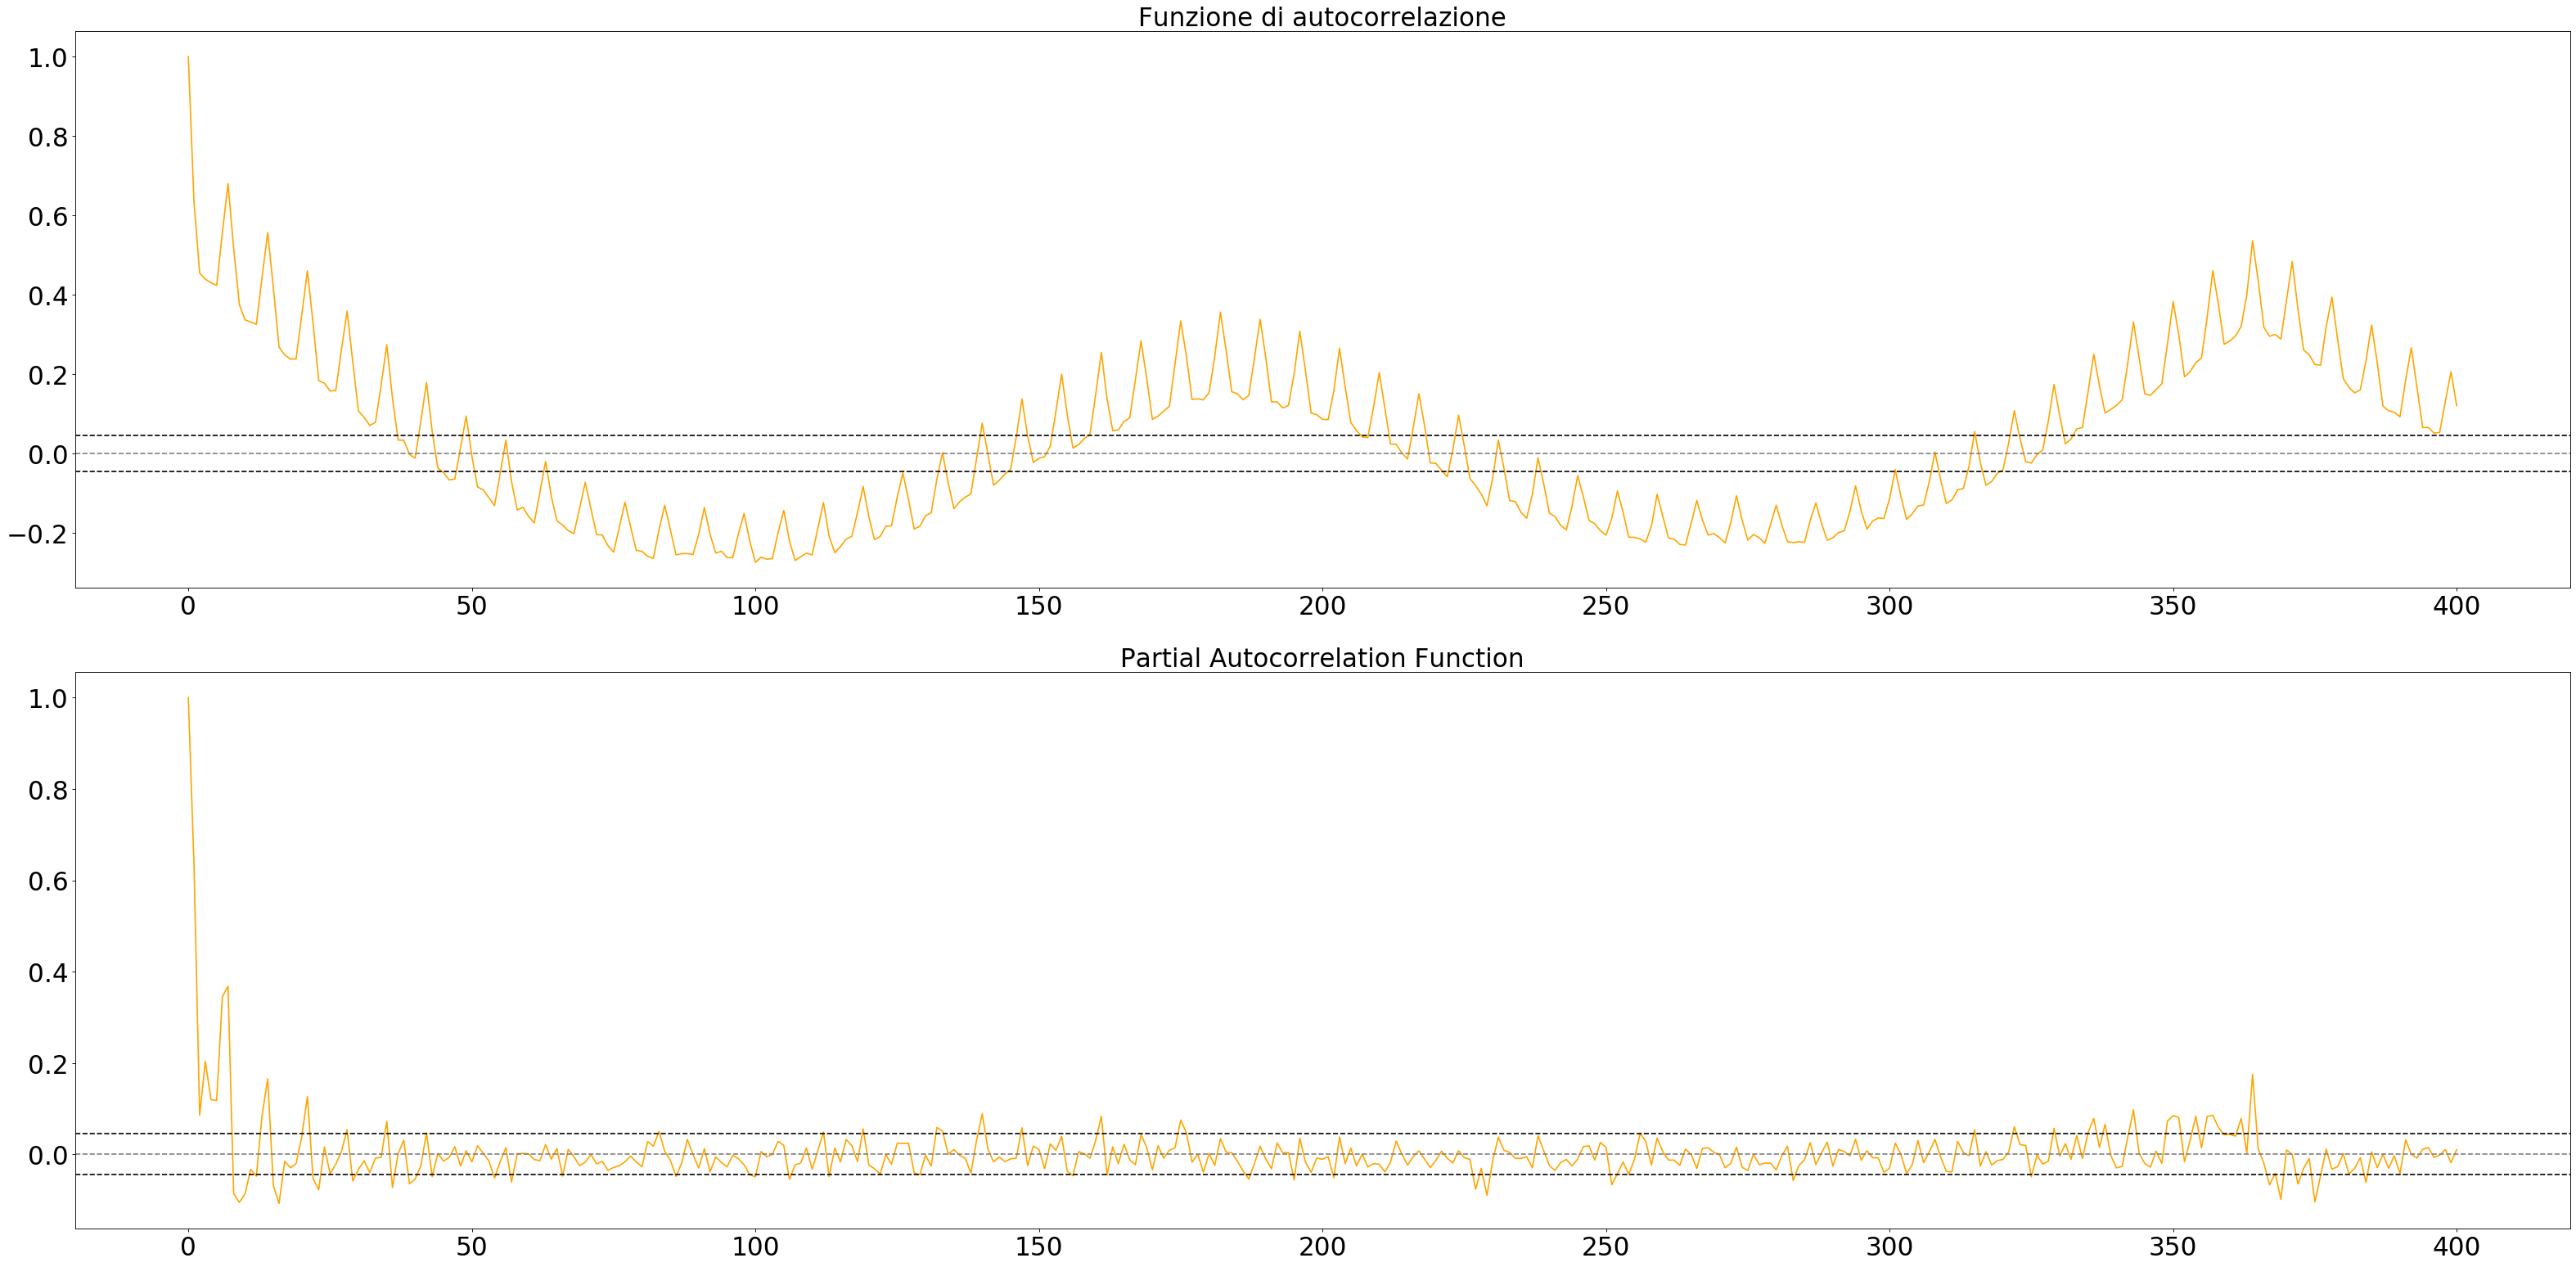

In [20]:
ac_pac_function(train, lags = 400)

La forza della stagionalità di periodo 183 è: 0.4036207302033452


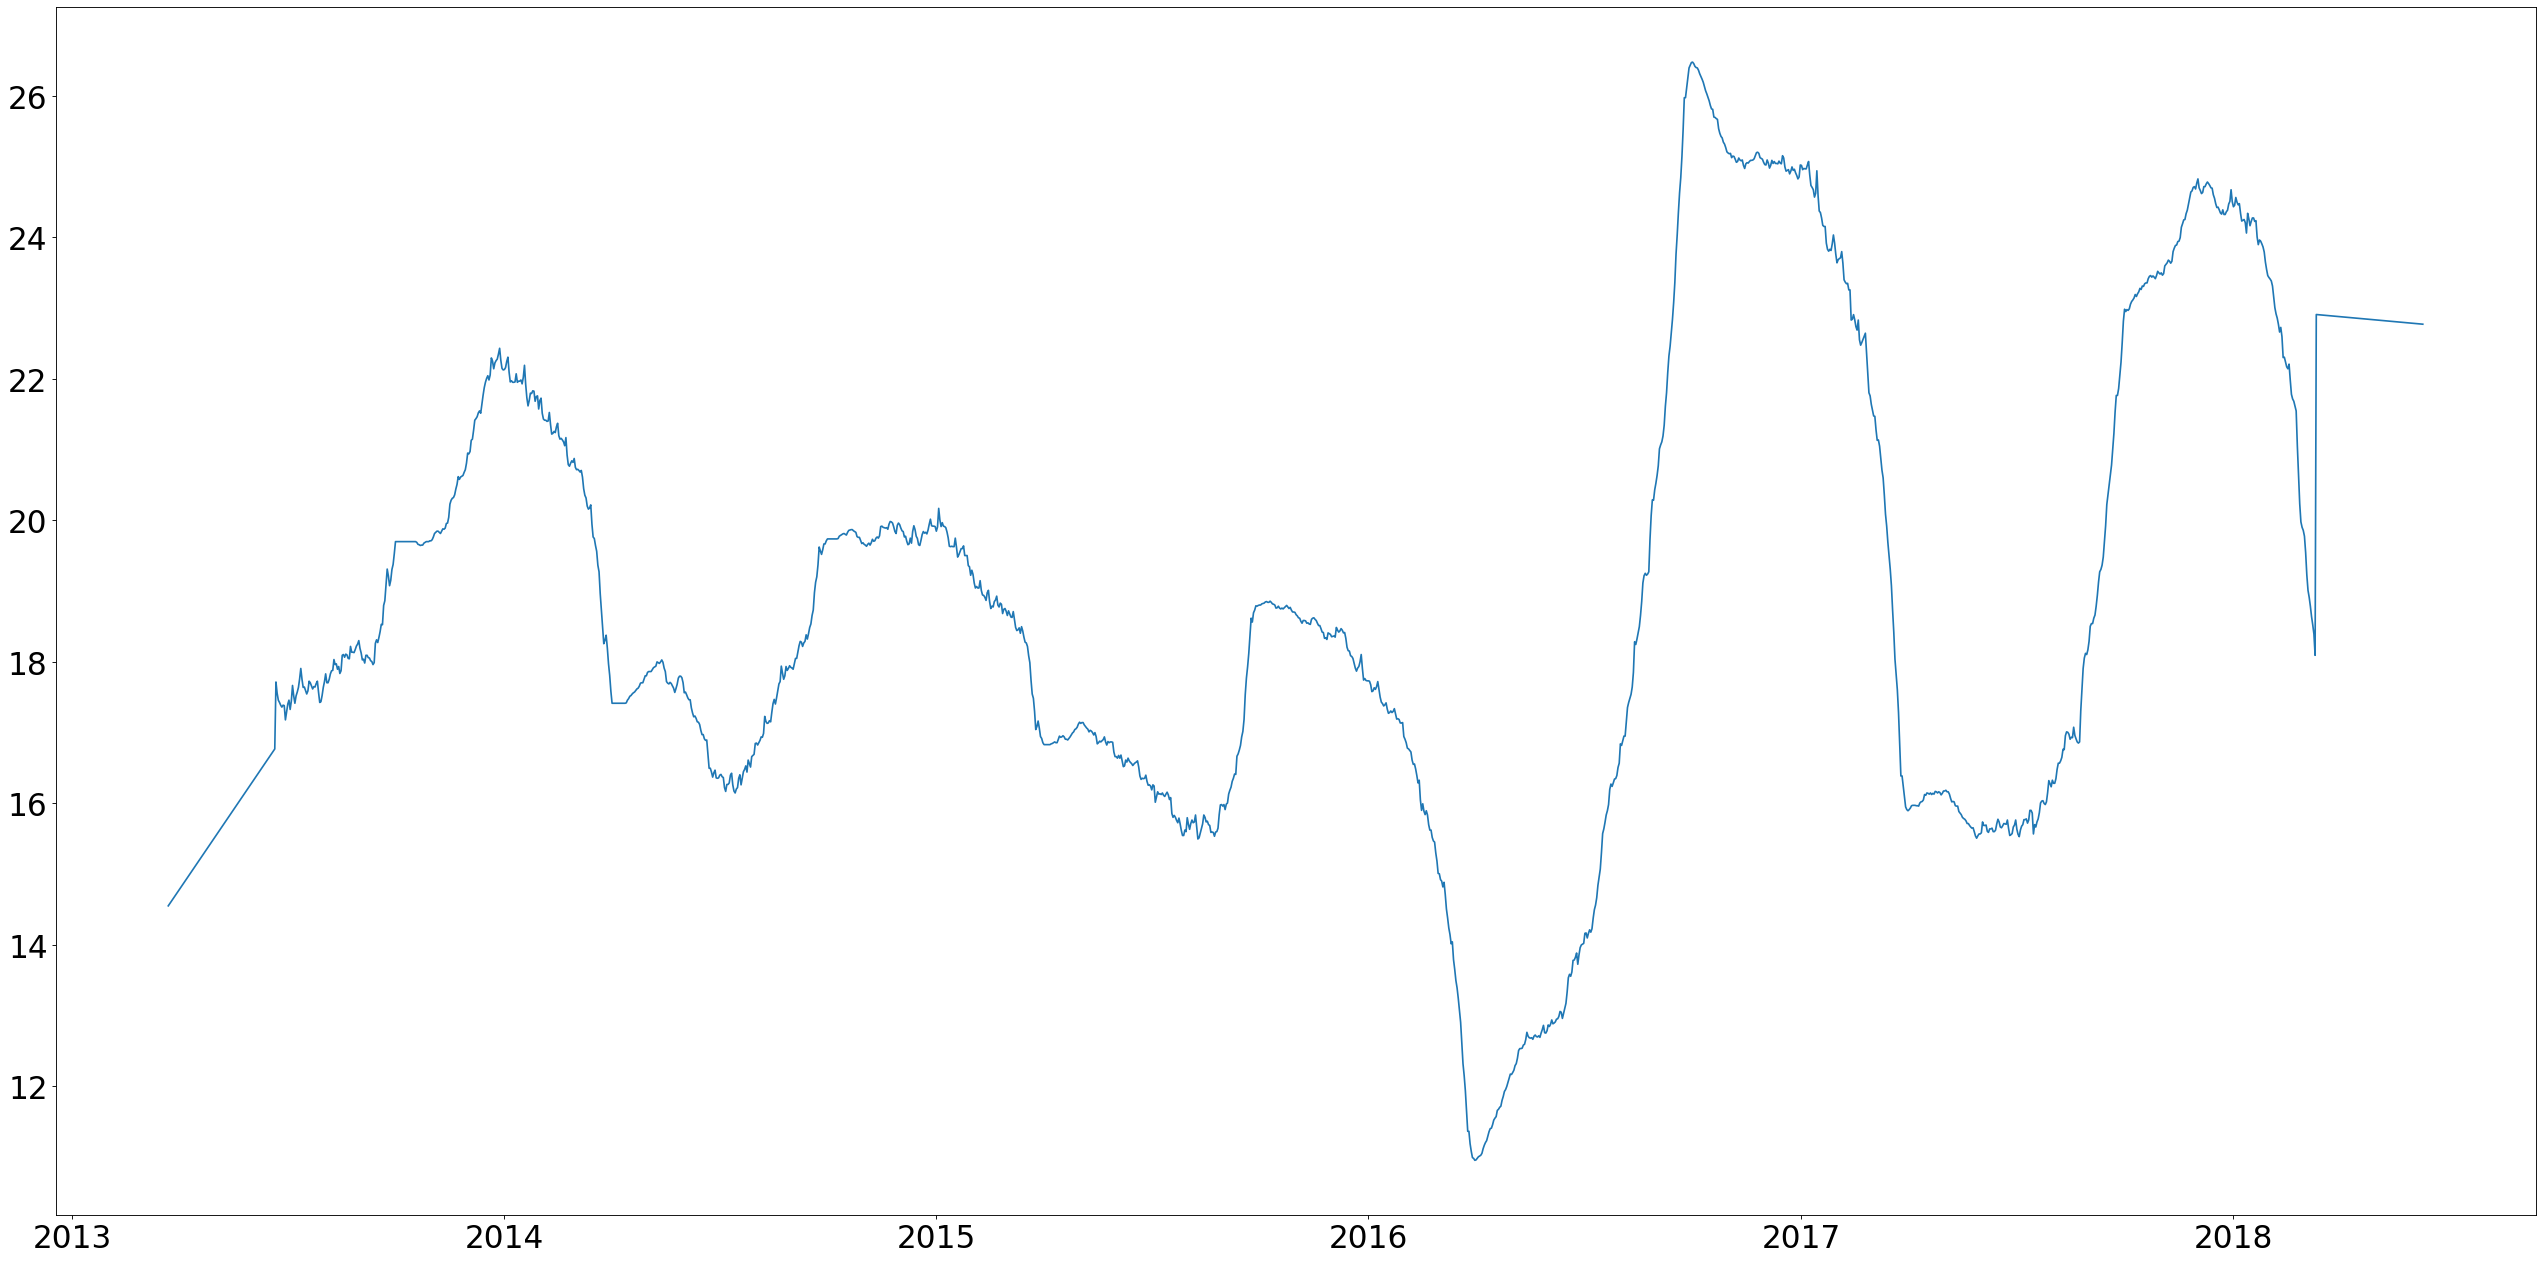

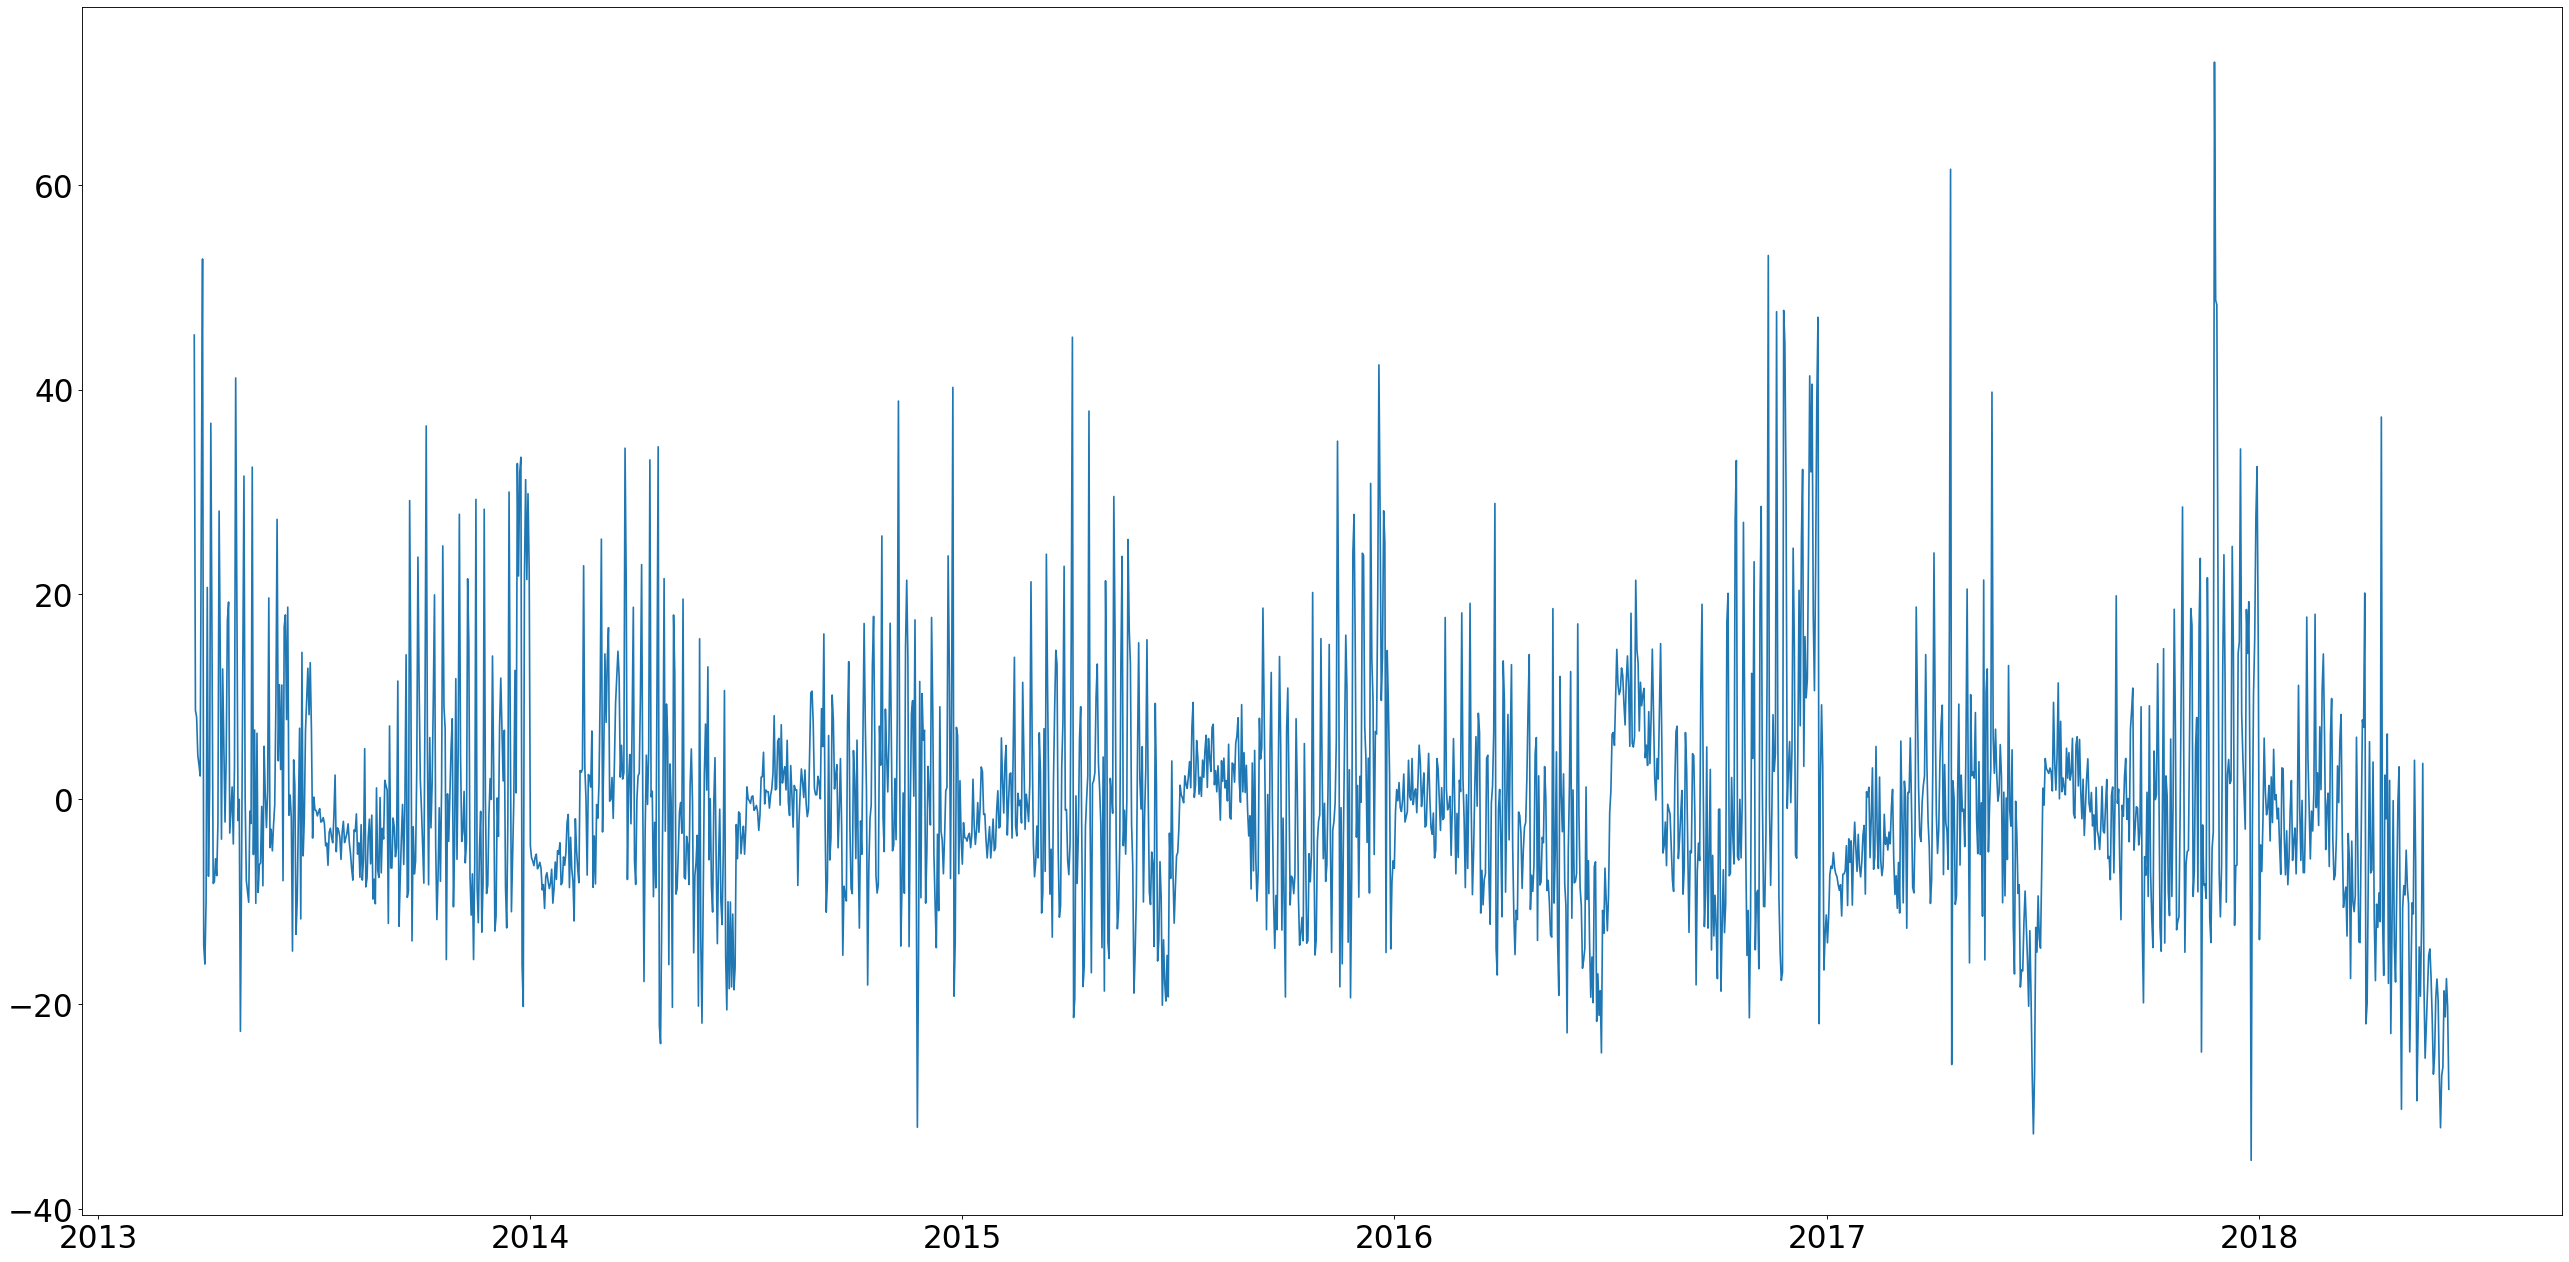

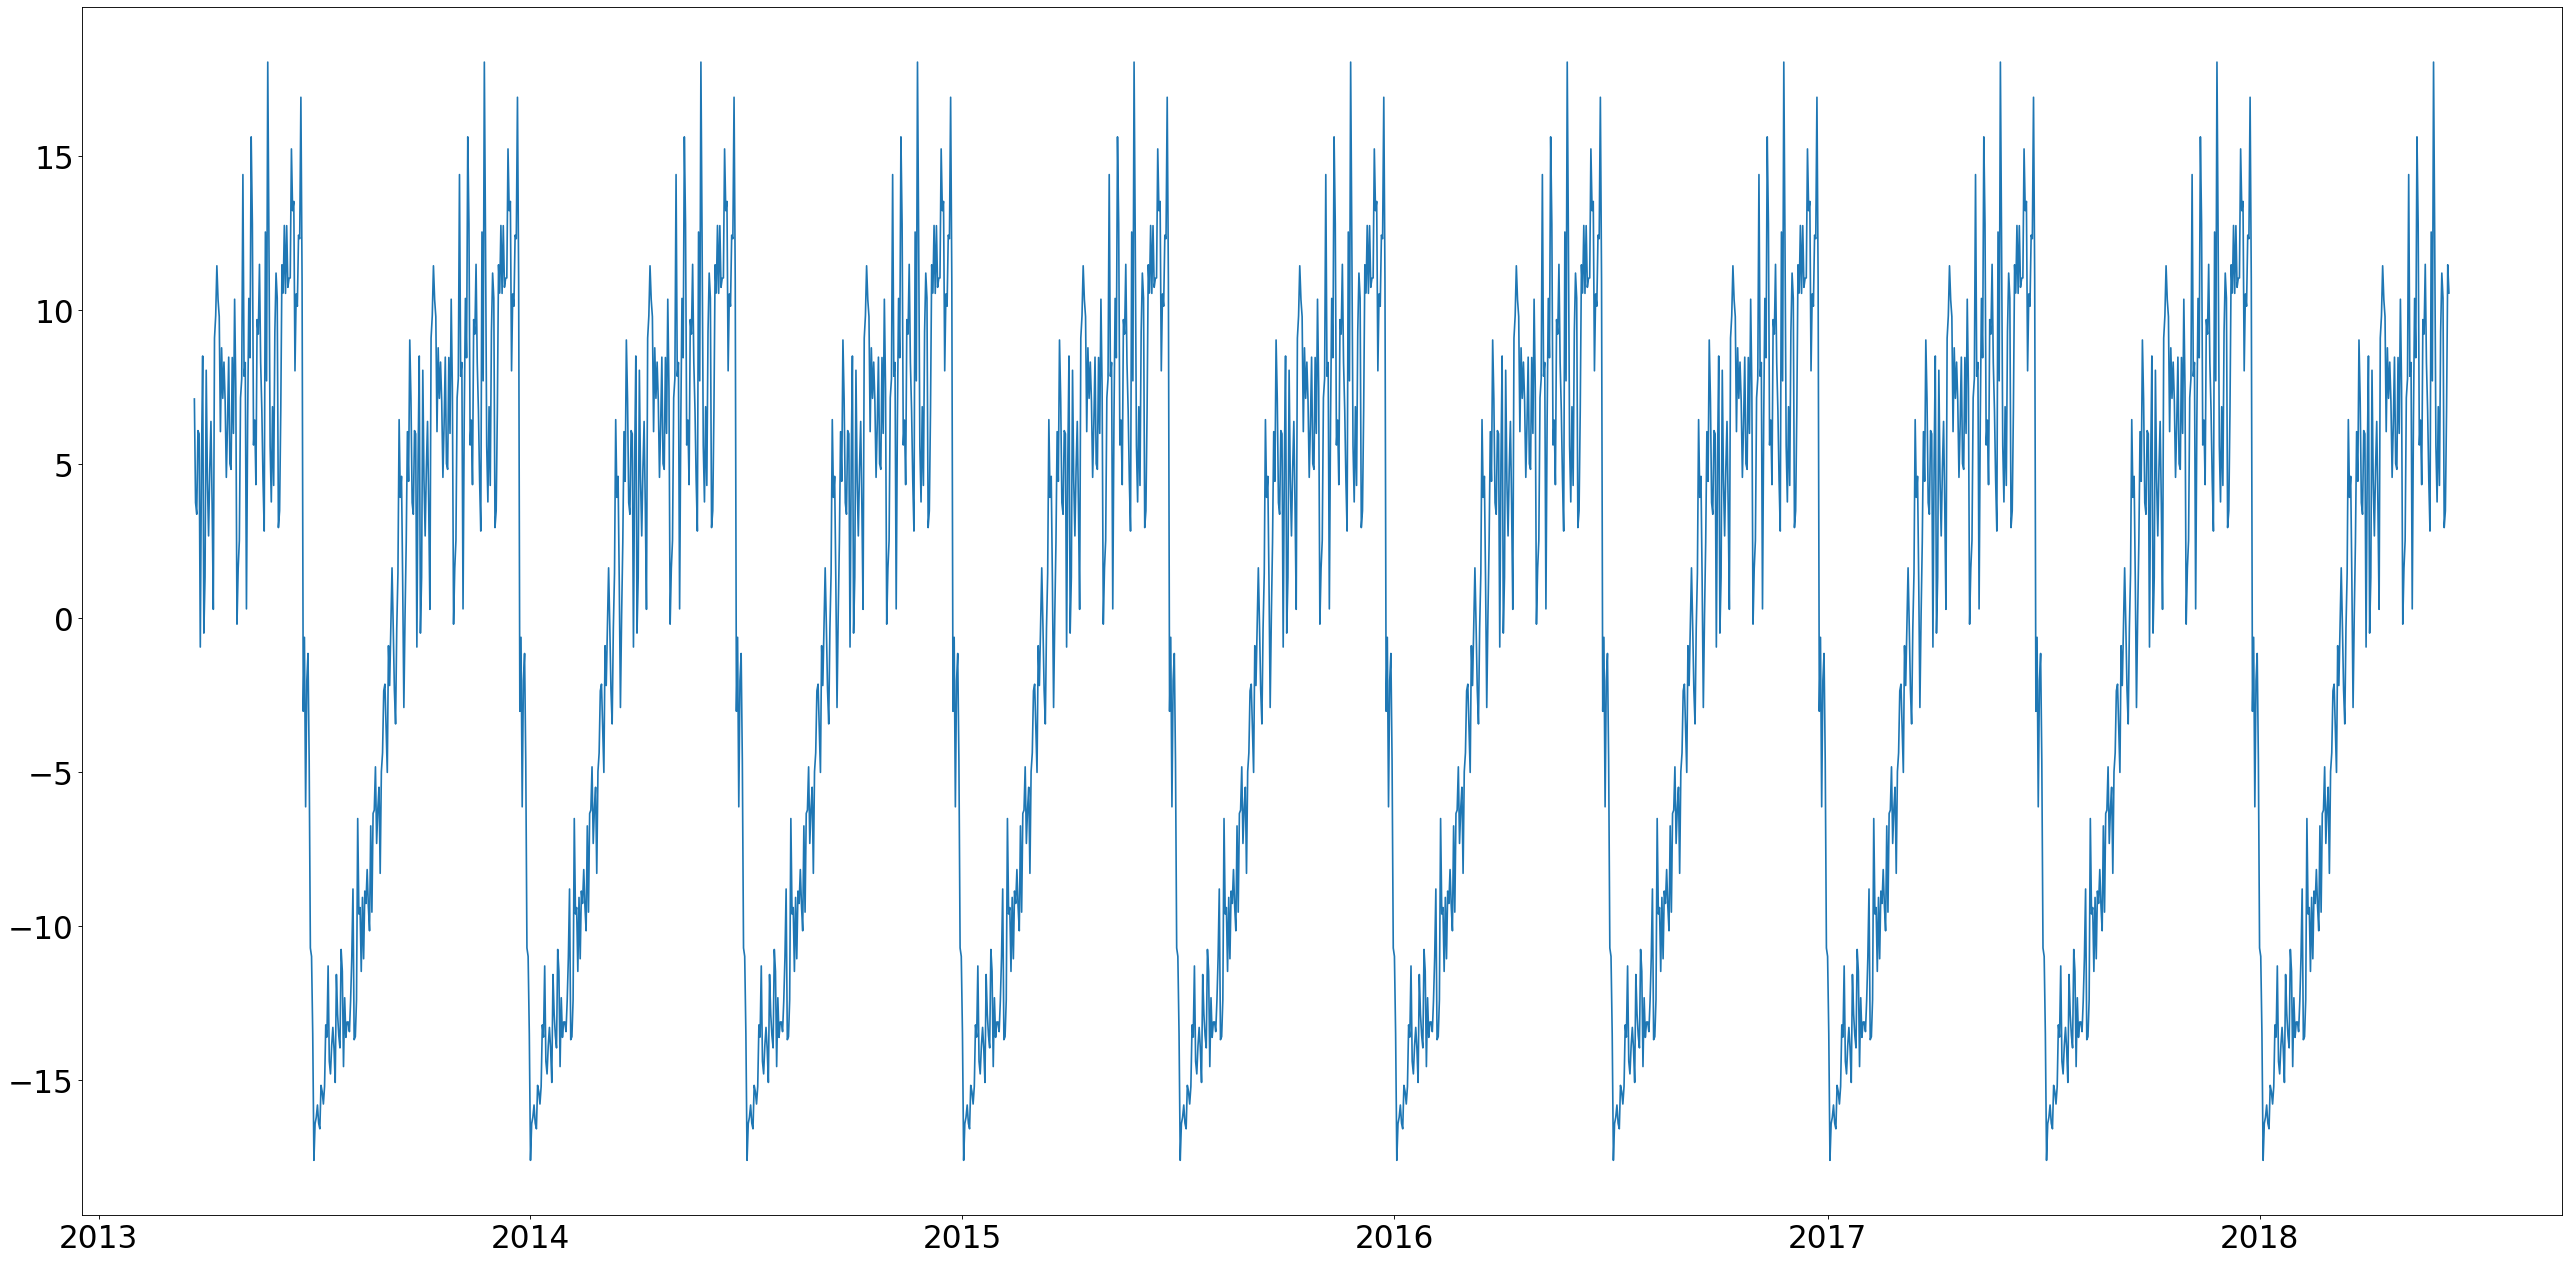

In [21]:
#%%
# Decompongo la serie
# con periodo di 365 o 183 giorni (year e half_year)

result = seasonal_decompose(train,  model = 'additive', period = season, extrapolate_trend='freq')

#%%

trend = result.trend
seasonality = result.seasonal
residuals = result.resid

strength_seasonal = max(0, 1 - residuals.var()/(seasonality + residuals).var())
print('La forza della stagionalità di periodo {} è: {}'.format(season, strength_seasonal))

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(trend)
plt.figure(figsize=(40, 20), dpi=80)
plt.plot(residuals)
plt.figure(figsize=(40, 20), dpi=80)
plt.plot(seasonality)

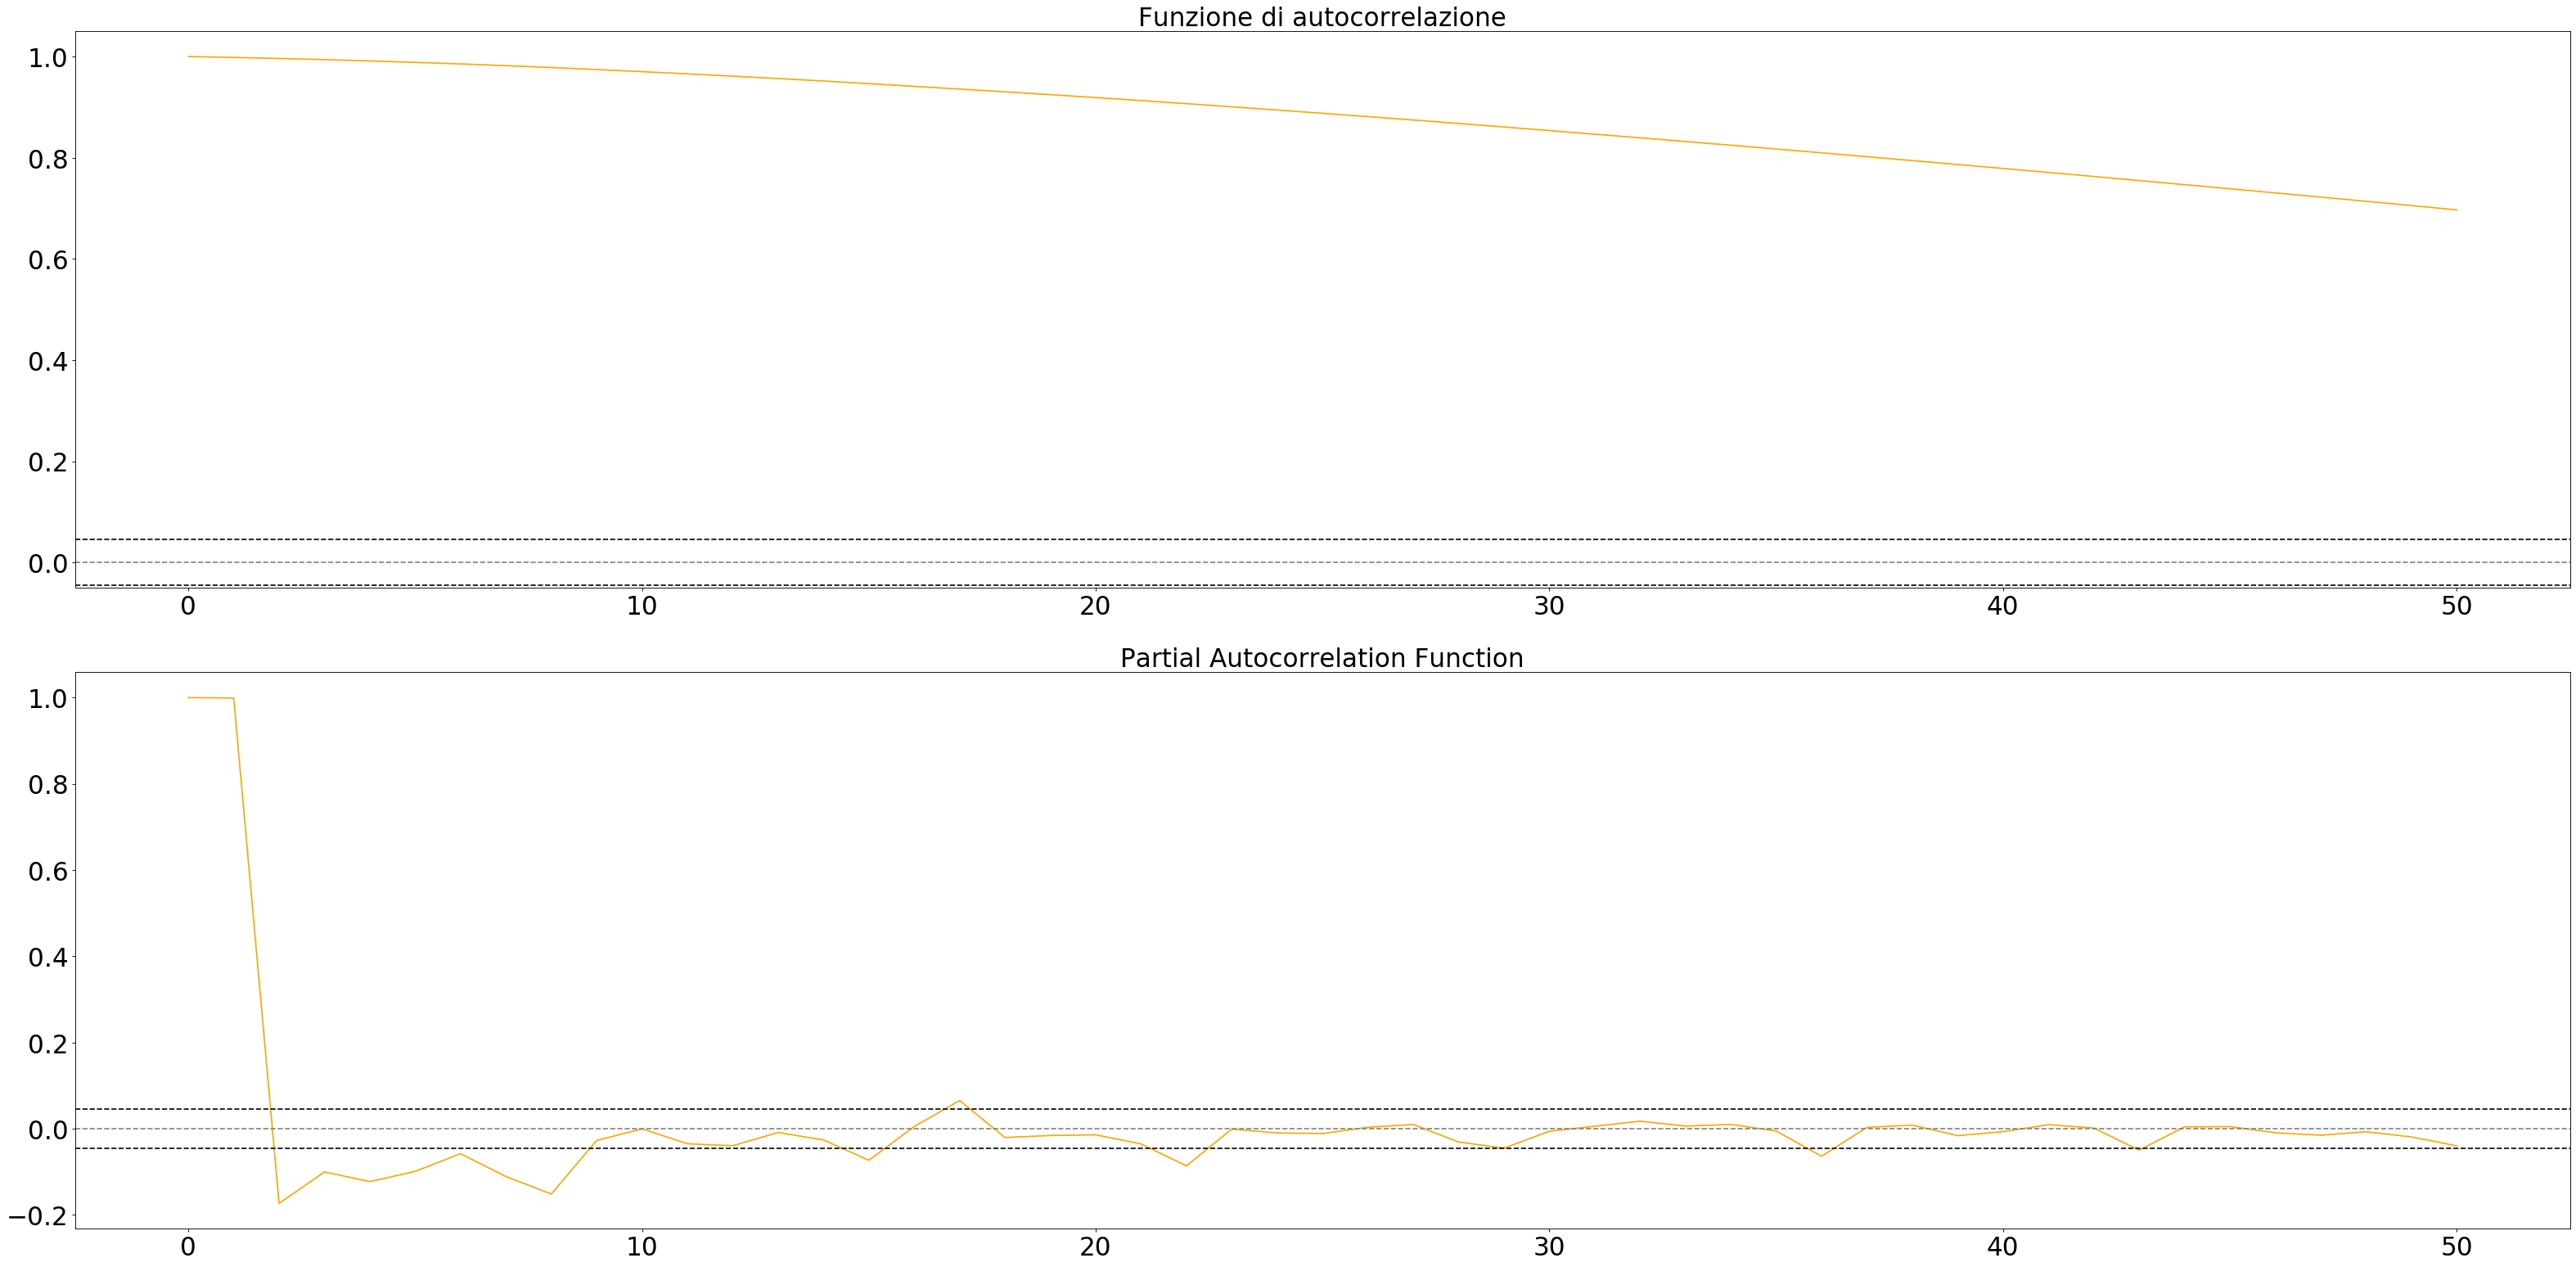

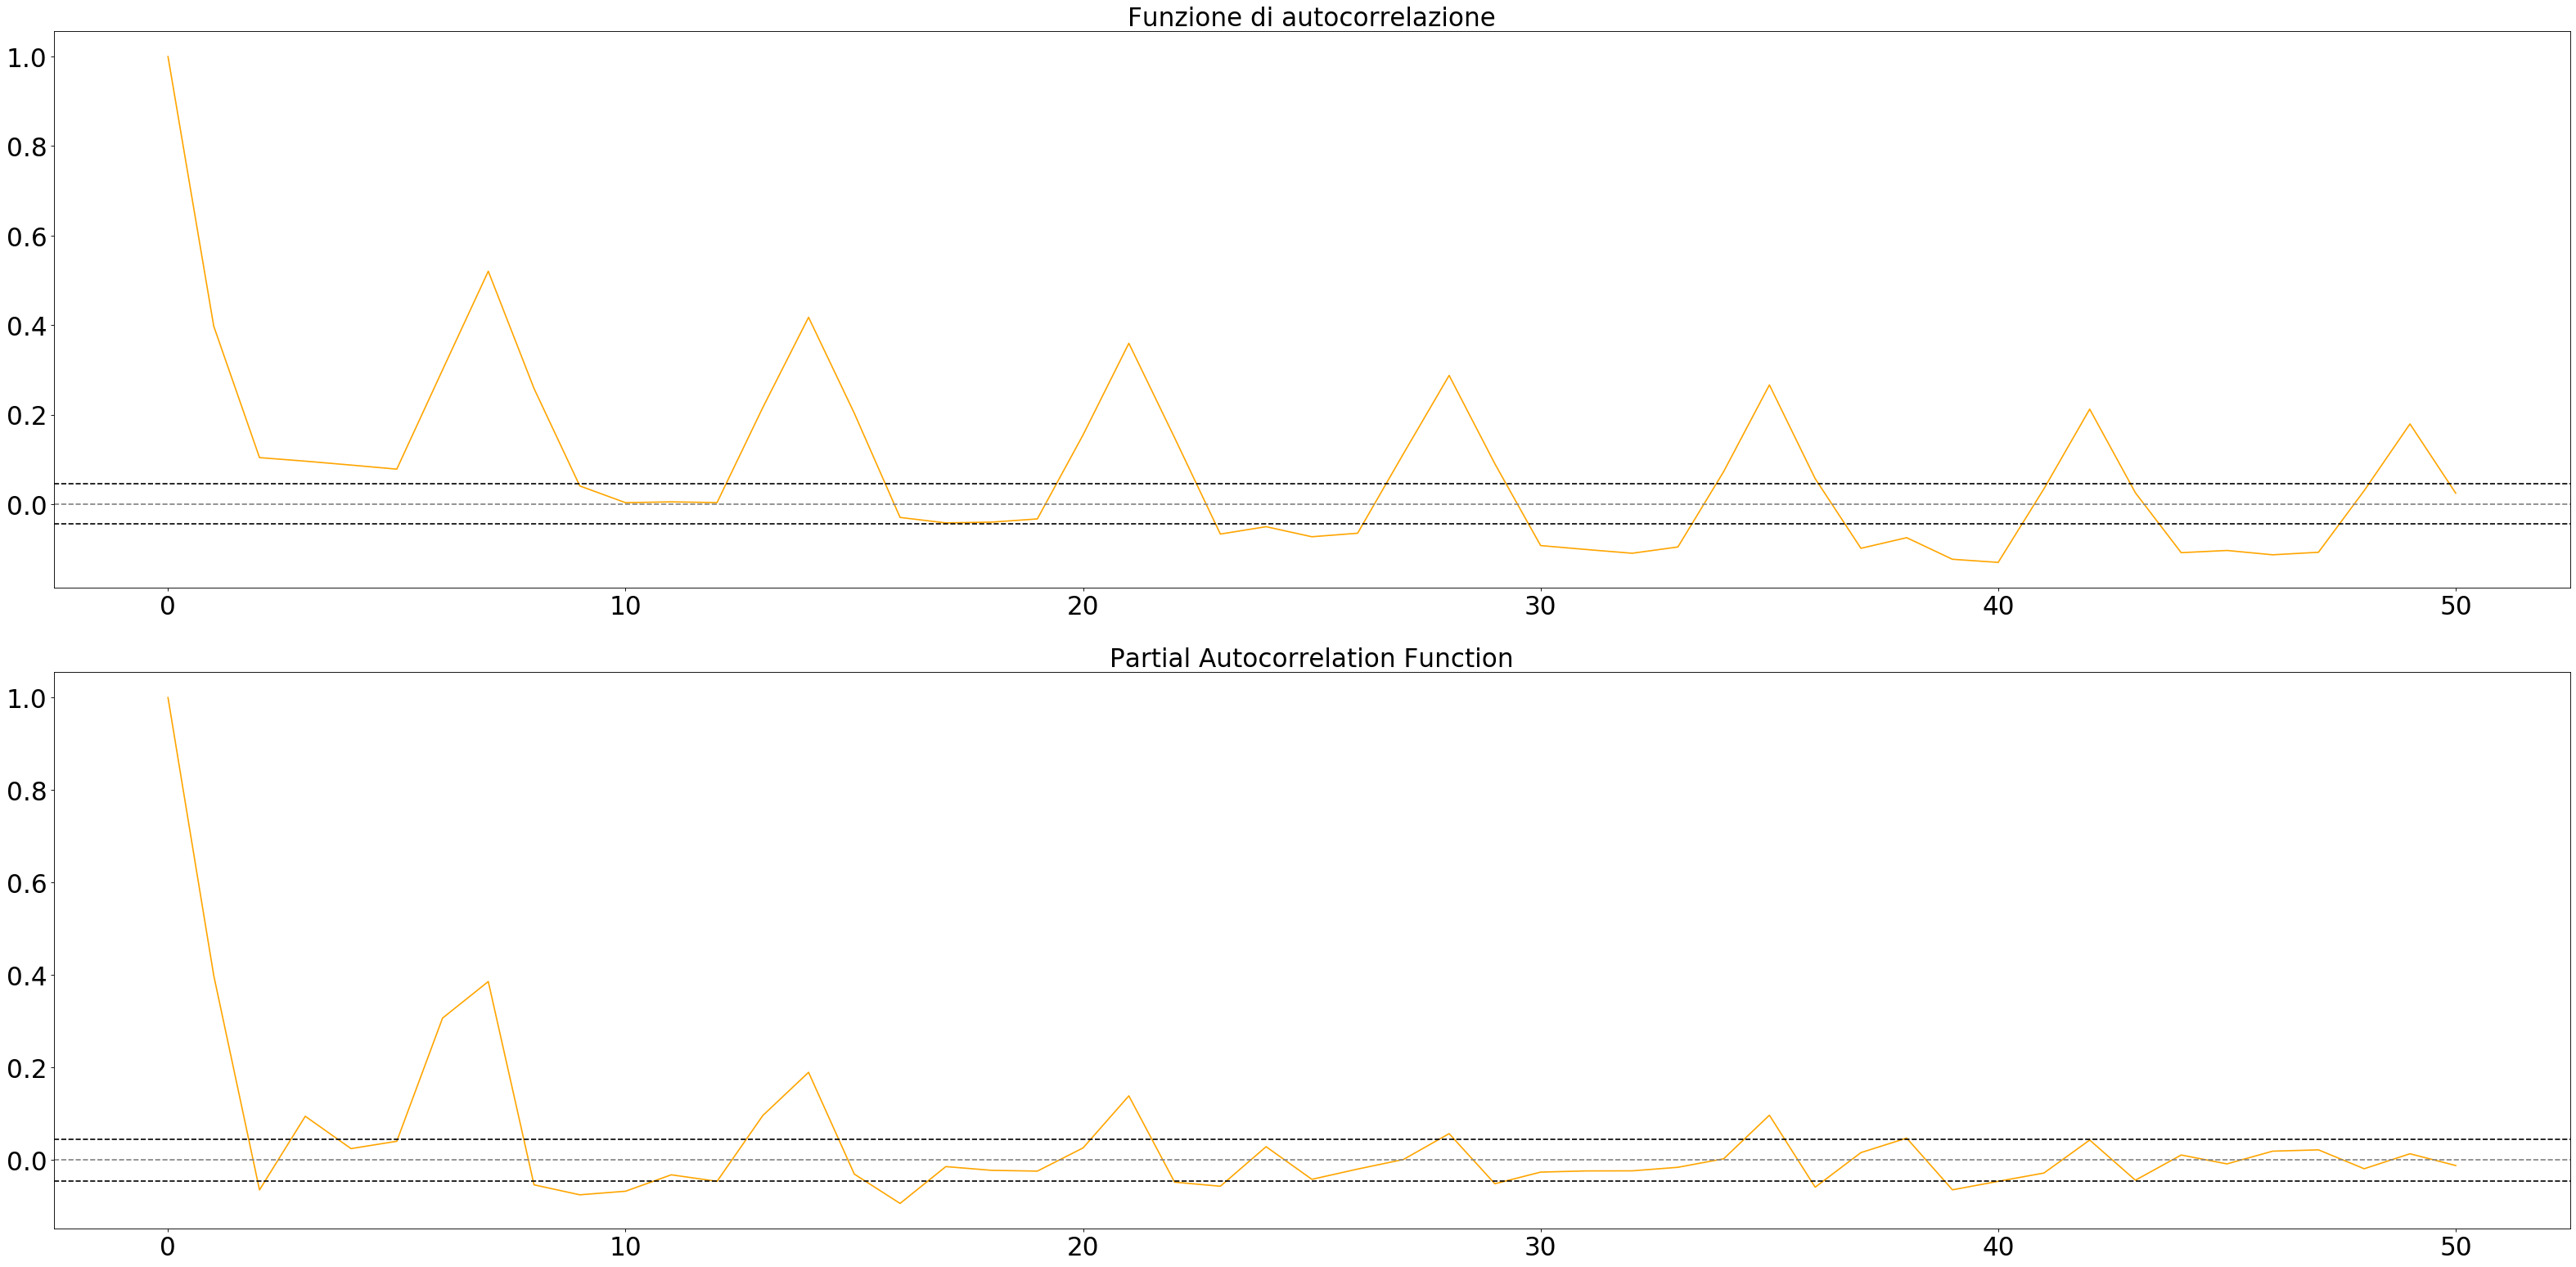

In [23]:
trend.dropna(inplace = True)
seasonality.dropna(inplace = True)
residuals.dropna(inplace = True)

ac_pac_function(trend, lags = 50)
ac_pac_function(residuals, lags = 50)

In [ ]:
p = q = range(0, 6)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))

# genero le previsioni della componente trend

best = None
best_AIC = None
for param in pdq:
    try:
        mod = ARIMA(trend, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if best is None:
            best = param
            best_AIC = results.aic
        elif results.aic < best_AIC:
            best_AIC = results.aic
            best = param
    except:
        continue

print('Gli ordini scelti per il trend sono {} con un AIC di {}'.format(best, best_AIC))

trend_model = ARIMA(trend, order=best)
trend_fitted = trend_model.fit()

#fitted.summary()

trend_predictions, _, confidence_int = trend_fitted.forecast(steps = len(valid))
ts_trend_predictions = pd.Series(trend_predictions, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D')) 

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(trend, label='trend')
plt.plot(ts_trend_predictions, label='previsione trend')
plt.legend(loc = 'best')

In [ ]:
# genero le previsioni della componente residuals

best = None
best_AIC = None
for param in pdq:
    try:
        mod = ARIMA(residuals, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if best is None:
            best = param
            best_AIC = results.aic
        elif results.aic < best_AIC:
            best_AIC = results.aic
            best = param
    except:
        continue

print('Gli ordini scelti per i residui sono {} con un AIC di {}'.format(best, best_AIC))

residuals_model = ARIMA(residuals, order=best)
residuals_fitted = residuals_model.fit()

#fitted.summary()

residuals_predictions, _, confidence_int = residuals_fitted.forecast(steps = len(valid))
ts_residuals_predictions = pd.Series(residuals_predictions, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D')) 

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(residuals, label='residui')
plt.plot(ts_residuals_predictions, label='previsione residui')
plt.legend(loc = 'best')

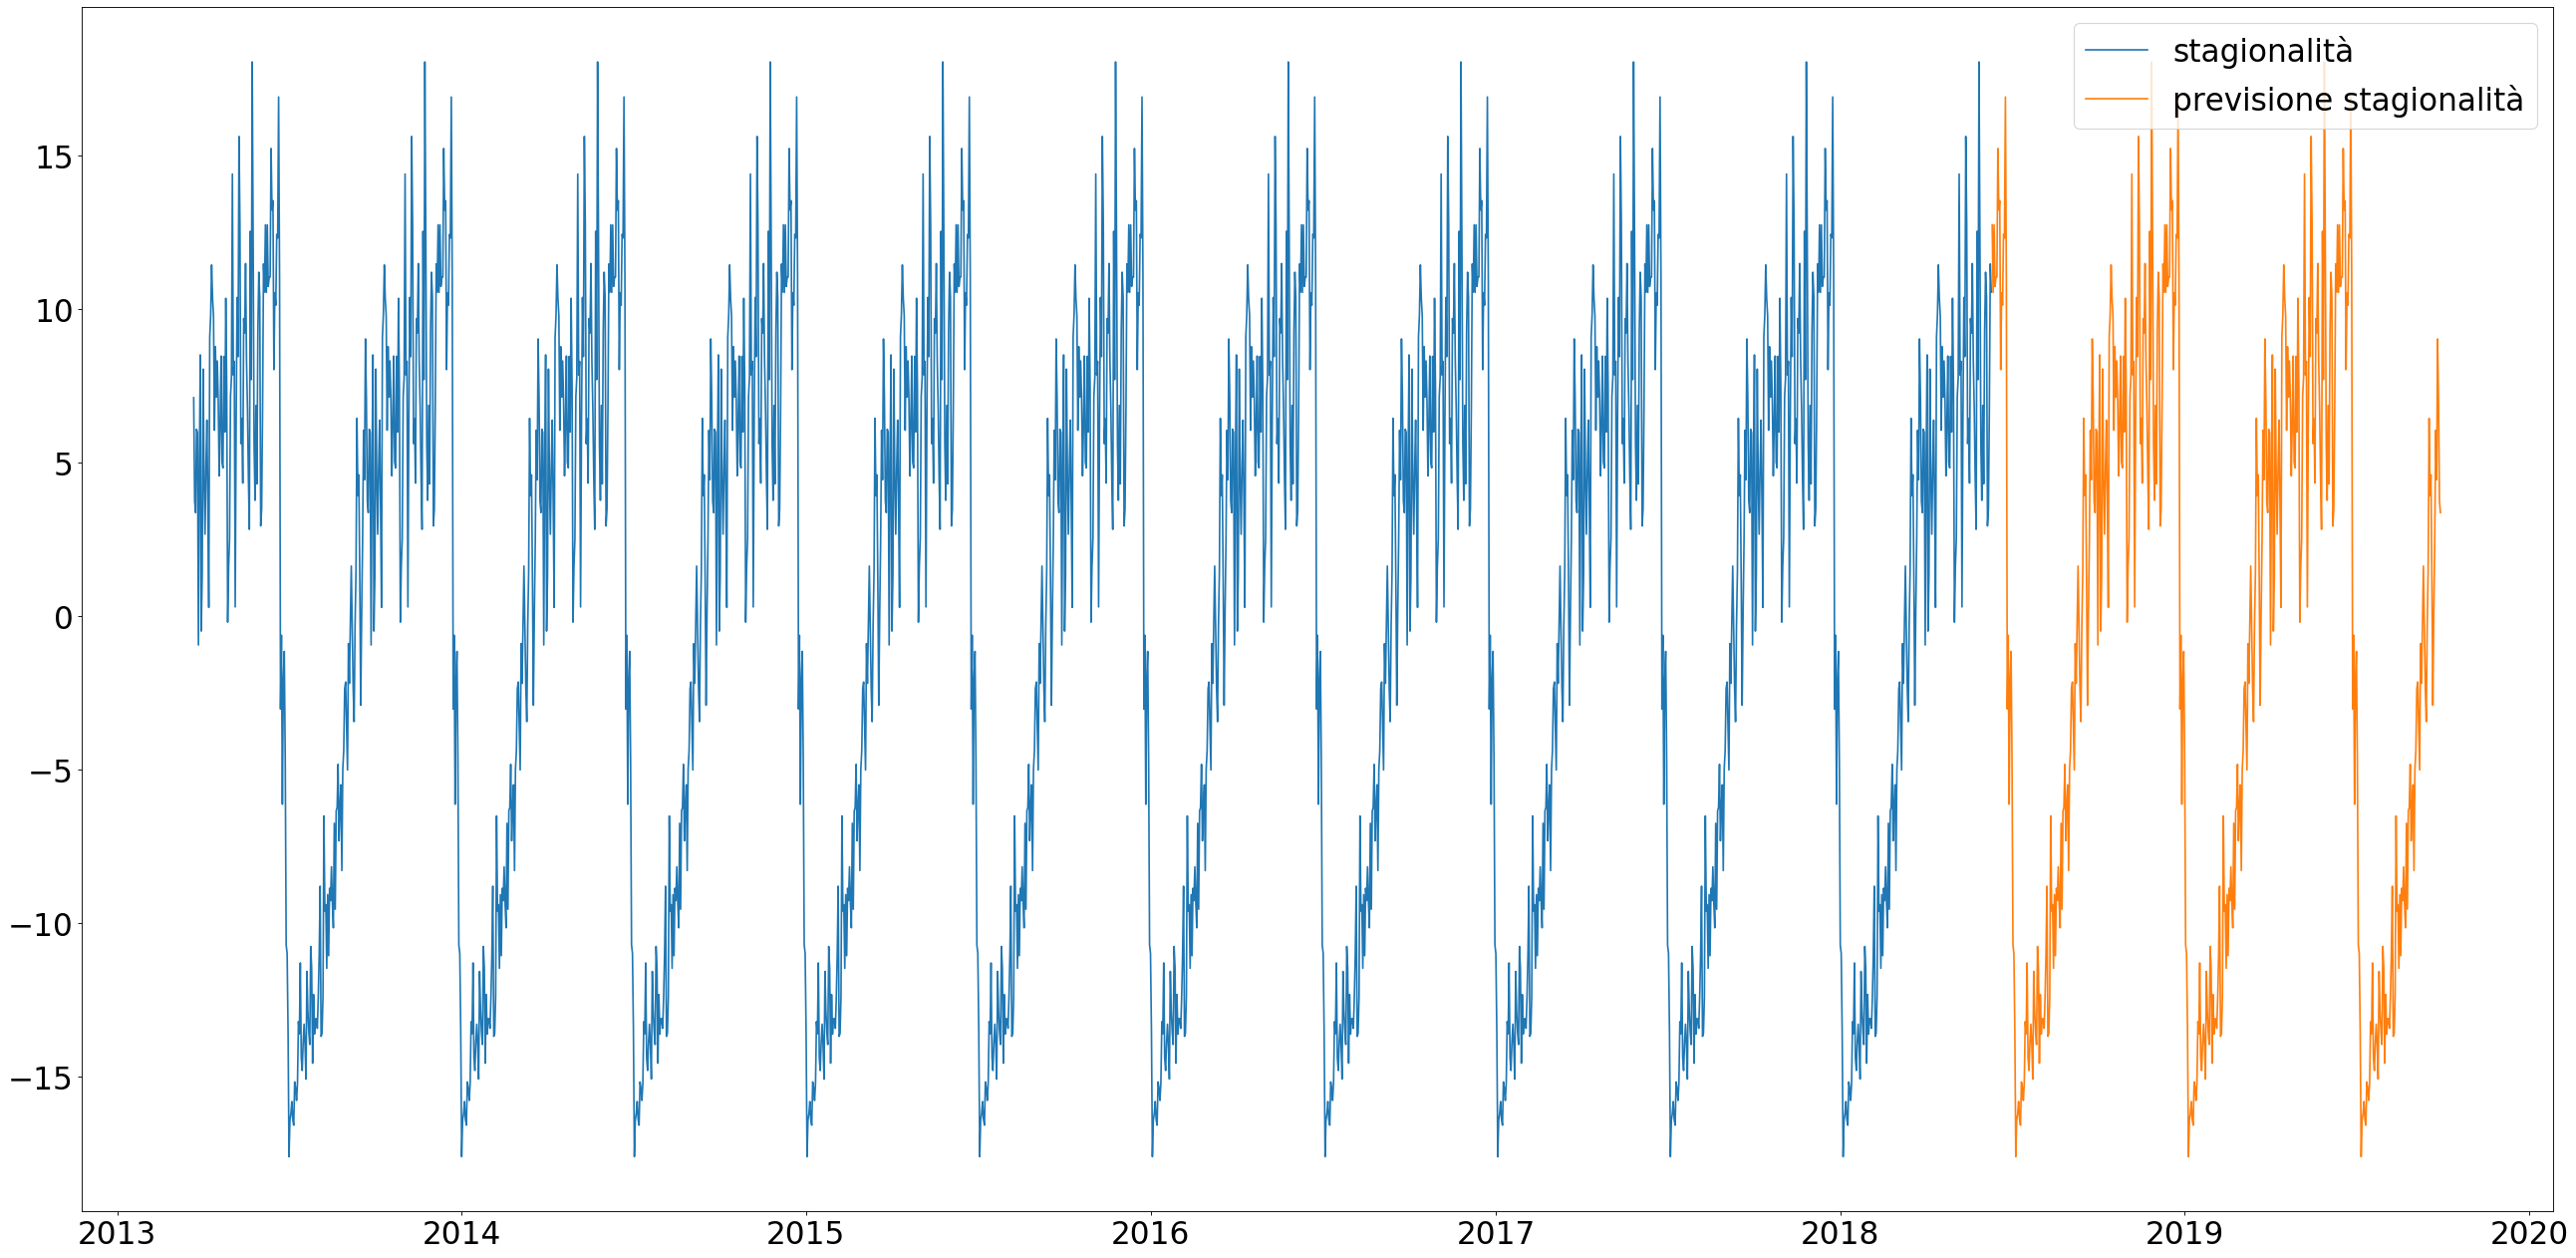

In [24]:
# genere le previsioni della componente stagionale usando il metodo seasonal naive

predictions_seasonality = []
for i in range (0, len(valid)):
    if i < season:
        predictions_seasonality.append(seasonality[len(seasonality)-season+i])
    else:
        predictions_seasonality.append(predictions_seasonality[i%season])

# produca la serie temporale dalla lista di valori usando come indice le date del validation set        

ts_predictions_seasonality = pd.Series(predictions_seasonality, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D'))

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(seasonality, label='stagionalità')
plt.plot(ts_predictions_seasonality, label='previsione stagionalità')
plt.legend(loc='best');

In [ ]:
# Torno alla forma iniziale sommando le componenti

model = trend_fitted.fittedvalues + residuals_fitted.fittedvalues + seasonality

# Calcolo le previsioni (per un periodo come valid, con cui fare il confronto
# per determinarne la bontà)

predictions = ts_residuals_predictions + ts_predictions_seasonality + ts_trend_predictions

for i in range (0, len(model)):
    if model[i] < 0:
        model[i] = 0

for i in range (0, len(predictions)):
    if predictions[i] < 0:
        predictions[i] = 0

# Plot del modello ARIMA con la serie per il training in scala originale

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(train, label = "Training set", color = 'black')
plt.plot(model, color='green', label='modello')
plt.plot(valid, color='black', linestyle='--', label = 'Validation set')
plt.legend(loc='best');

In [ ]:
# Per ottenere le previsioni in scala originale devo aggiungere la componente stagionale
# (settimanale) che posso ottenere con una media esponenziale o un "approccio naive" ossia
# prendendo la stagionalità di k osservazioni passate

ci = 1.96 * np.std(predictions)/np.mean(predictions)
plt.plot(predictions, color="red", label='previsioni')
plt.xlabel('Data')
plt.ylabel('#Maglie vendute')
plt.legend(loc='best')
print(predictions.head())

errore = predictions - valid
errore.dropna(inplace=True)

print("Calcoliamo  MAE=%.4f"%(sum(abs(errore))/len(errore)))
print('Calcoliamo MSE: %.4f'%(sum((predictions-valid)**2)/len(valid)))